####  load inputs

In [18]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.stats import genextreme


In [19]:
# ============================================================
# LOAD EVT PARAMETERS (FROM YOUR FIT)
# ============================================================

# These must match your fitted values
MU = 48.47       # mm
SIGMA = 15.35    # mm
XI = 0.094       # shape

# SciPy convention
SHAPE = -XI


In [20]:
# ============================================================
# EVT NORMALISATION ANCHOR (100-YEAR RAINFALL)
# ============================================================

R100 = 136.87     # mm (from your EVT table)
assert R100 > 0, "R100 must be positive"


In [21]:
# ============================================================
# LOAD FACILITY DAMAGE DATA (100-YR AS ANCHOR)
# ============================================================

waste = gpd.read_file(
    "/vol/sandeep_storage/Files2/catastrophe/osm/"
    "waste_facilities_damage_scenarios_evt.geojson"
).to_crs(epsg=4326)

print("Loaded facilities:", len(waste))

assert "flood_hazard_index" in waste.columns, "Missing flood_hazard_index!"


Loaded facilities: 16


In [22]:
waste


facility_type  dist_to_drainage_m  vuln_drainage  elevation_m  \
0   wastewater_plant         1175.916986       0.764817        515.0   
1   wastewater_plant          159.951078       0.968010        502.0   
2           landfill         3187.375573       0.362525        495.0   
3   wastewater_plant           28.441820       0.994312        518.0   
4   transfer_station          168.646433       0.966271        528.0   
5   wastewater_plant          873.892710       0.825221        532.0   
6   wastewater_plant          303.693938       0.939261        526.0   
7   wastewater_plant         1211.262999       0.757747        493.0   
8   wastewater_plant          568.492664       0.886301        525.0   
9           landfill         2460.283916       0.507943        515.0   
10  transfer_station          396.378695       0.920724        521.0   
11  wastewater_plant         3629.969350       0.274006        515.0   
12  wastewater_plant         3927.273430       0.214545        507.0   
13  transfer_station         3257.044867       0.348591        499.0   
14  wastewater_plant         1685.604313       0.662879        518.0   
15  wastewater_plant           68.165946       0.986367        505.0   

    elev_percentile  vuln_elevation  slope_deg  slope_percentile  vuln_slope  \
0           0.50000         0.50000   1.238635           0.93750     0.06250   
1           0.25000         0.75000   0.699146           0.46875     0.53125   
2           0.12500         0.87500   0.972854           0.71875     0.28125   
3           0.65625         0.34375   0.718740           0.62500     0.37500   
4           0.93750         0.06250   0.448432           0.18750     0.81250   
5           1.00000         0.00000   0.000000           0.09375     0.90625   
6           0.87500         0.12500   0.984000           0.81250     0.18750   
7           0.06250         0.93750   0.972854           0.71875     0.28125   
8           0.81250         0.18750   1.280363           1.00000     0.00000   
9           0.50000         0.50000   0.619390           0.25000     0.75000   
10          0.75000         0.25000   0.000000           0.09375     0.90625   
11          0.50000         0.50000   0.699146           0.46875     0.53125   
12          0.37500         0.62500   1.132984           0.87500     0.12500   
13          0.18750         0.81250   0.699146           0.46875     0.53125   
14          0.65625         0.34375   0.699146           0.46875     0.53125   
15          0.31250         0.68750   0.648604           0.31250     0.68750   

    flood_hazard_index  ... hazard_25yr  hazard_50yr  hazard_100yr  \
0             0.531667  ...    0.410891     0.469511      0.531667   
1             0.804354  ...    0.621632     0.710318      0.804354   
2             0.525636  ...    0.406229     0.464184      0.525636   
3             0.642753  ...    0.496741     0.567609      0.642753   
4             0.619197  ...    0.478536     0.546807      0.619197   
5             0.552600  ...    0.427068     0.487996      0.552600   
6             0.503918  ...    0.389444     0.445005      0.503918   
7             0.725361  ...    0.560584     0.640560      0.725361   
8             0.464461  ...    0.358951     0.410161      0.464461   
9             0.553574  ...    0.427821     0.488856      0.553574   
10            0.683076  ...    0.527904     0.603218      0.683076   
11            0.404553  ...    0.312652     0.357257      0.404553   
12            0.340295  ...    0.262992     0.300512      0.340295   
13            0.547491  ...    0.423119     0.483484      0.547491   
14            0.524858  ...    0.405628     0.463497      0.524858   
15            0.821990  ...    0.635262     0.725892      0.821990   

    damage_2yr  damage_5yr  damage_10yr  damage_25yr  damage_50yr  \
0     0.131906    0.194998     0.243901     0.314662     0.374230   
1     0.225951    0.334025     0.417795     0.539006     0.641045   
2     0.043316    0.079

In [23]:

# ============================================================
# ASSET VALUES  (RELATIVE SCALE – INSURANCE GRADE)
# ============================================================

ASSET_VALUE = {
    "wastewater_plant": 5e7,
    "landfill": 2e7,
    "transfer_station": 1.5e7,
    "recycling": 1e7,
    "other": 1e7
}
DEFAULT_VALUE = 1e7


In [24]:

# ============================================================
# EVENT FREQUENCY MODEL
# ============================================================

LAMBDA_EVENTS = 0.4   # floods per year (assume)
N_YEARS = 10000


In [25]:

# ============================================================
# MONTE CARLO SIMULATION
# ============================================================

annual_losses = []

for _ in range(N_YEARS):

    # Number of flood events this year
    n_events = np.random.poisson(LAMBDA_EVENTS)

    year_loss = 0.0

    for _ in range(n_events):

        # Sample rainfall severity
        rainfall = genextreme.rvs(
            SHAPE,
            loc=MU,
            scale=SIGMA
        )

        if rainfall <= 0:
            continue

        # Convert rainfall → event hazard index
        event_hazard = min(rainfall / R100, 1.0)

        # Loop over facilities..(facility-level losses)
        for _, row in waste.iterrows():

            ftype = row["facility_type"]
            asset = ASSET_VALUE.get(ftype, DEFAULT_VALUE)

            # Facility-specific hazard scaling
            facility_hazard = (
                row["flood_hazard_index"] * event_hazard
            )

            facility_hazard = min(facility_hazard, 1.0)

            # Damage function (consistent with EVT curves)
            damage_ratio = facility_hazard ** 1.5
            damage_ratio = min(damage_ratio, 1.0)

            # Financial loss
            year_loss += asset * damage_ratio

    annual_losses.append(year_loss)

annual_losses = np.array(annual_losses)


In [26]:

# ============================================================
# EP CURVE + AAL
# ============================================================

loss_sorted = np.sort(annual_losses)[::-1]
ep = np.arange(1, N_YEARS + 1) / (N_YEARS + 1)

AAL = annual_losses.mean()

print(f"Average Annual Loss (AAL): {AAL:,.2f}")


Average Annual Loss (AAL): 32,889,135.07


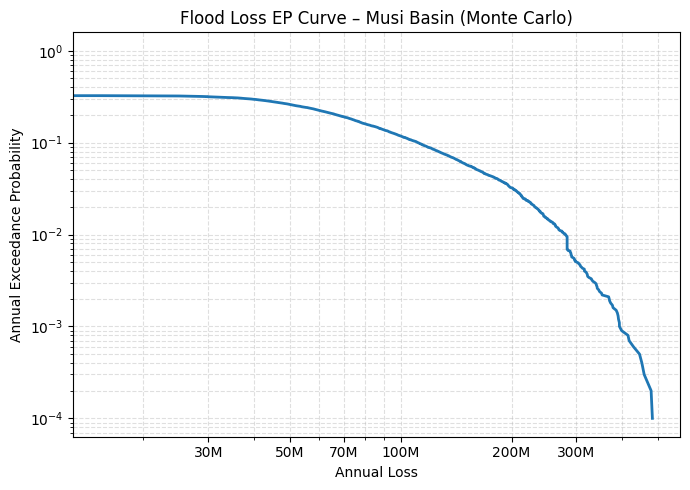

In [27]:

# ============================================================
# PLOT EP CURVE
# ============================================================
xticks = [3e7, 5e7, 7e7, 1e8, 2e8, 3e8]

plt.figure(figsize=(7, 5))
plt.plot(loss_sorted, ep, linewidth=2)

plt.xscale("log")
plt.yscale("log")

plt.xticks(
    xticks,
    [f"{int(x/1e6)}M" for x in xticks]
)

plt.xlabel("Annual Loss")
plt.ylabel("Annual Exceedance Probability")
plt.title("Flood Loss EP Curve – Musi Basin (Monte Carlo)")

plt.grid(True, which="both", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


In [28]:
probs = np.array([0.5, 0.2, 0.1, 0.04, 0.02, 0.01])
mc_losses = np.quantile(annual_losses, 1 - probs)

for p, L in zip(probs, mc_losses):
    print(f"EP={p:.2f} → Loss={L:,.2f}")


EP=0.50 → Loss=0.00
EP=0.20 → Loss=67,090,999.88
EP=0.10 → Loss=111,265,909.51
EP=0.04 → Loss=183,596,779.43
EP=0.02 → Loss=231,099,030.67
EP=0.01 → Loss=279,414,612.81


In [29]:
target_eps = [0.10, 0.05, 0.02, 0.01]

loss_at_ep = {
    p: np.percentile(annual_losses, 100 * (1 - p))
    for p in target_eps
}

for p, l in loss_at_ep.items():
    print(f"EP={int(p*100)}% → Loss = {l:,.0f}")


EP=10% → Loss = 111,265,910
EP=5% → Loss = 162,375,987
EP=2% → Loss = 231,099,031
EP=1% → Loss = 279,414,613


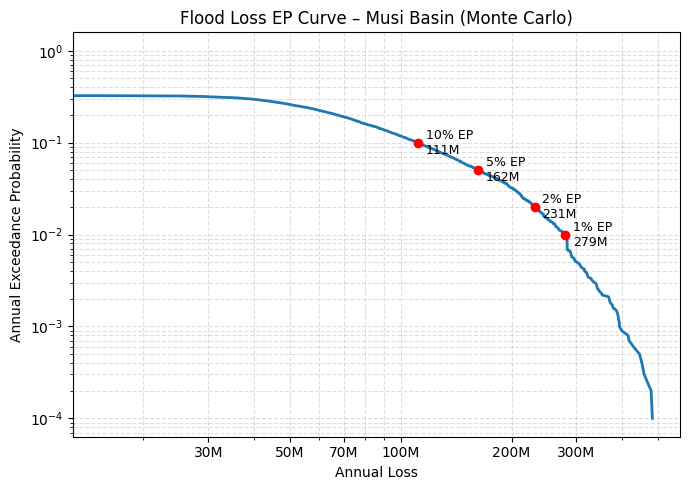

In [30]:
plt.figure(figsize=(7, 5))

# EP curve
plt.plot(loss_sorted, ep, linewidth=2, label="Monte Carlo EP")

# Mark important EP points
for p, loss in loss_at_ep.items():
    plt.scatter(
        loss, p,
        color="red",
        zorder=5
    )
    plt.text(
        loss * 1.05, p,
        f"{int(p*100)}% EP\n{loss/1e6:.0f}M",
        fontsize=9,
        va="center"
    )

plt.xscale("log")
plt.yscale("log")

plt.xticks(
    xticks,
    [f"{int(x/1e6)}M" for x in xticks]
)

plt.xlabel("Annual Loss")
plt.ylabel("Annual Exceedance Probability")
plt.title("Flood Loss EP Curve – Musi Basin (Monte Carlo)")

plt.grid(True, which="both", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


#### Occurrence Exceedance Probability (OEP) vs Aggregate Exceedance Probability (AEP)

In [31]:
N_YEARS = 10000
annual_aggregate_losses = []
annual_occurrence_losses = []

for _ in range(N_YEARS):

    n_events = np.random.poisson(LAMBDA_EVENTS)

    year_losses = []

    for _ in range(n_events):

        rainfall = genextreme.rvs(SHAPE, loc=MU, scale=SIGMA)
        if rainfall <= 0:
            continue

        event_hazard = min(rainfall / R100, 1.0)

        event_loss = 0.0

        for _, row in waste.iterrows():
            asset = ASSET_VALUE.get(row["facility_type"], DEFAULT_VALUE)

            facility_hazard = min(
                row["flood_hazard_index"] * event_hazard, 1.0
            )

            damage_ratio = min(facility_hazard ** 1.5, 1.0)
            event_loss += asset * damage_ratio

        year_losses.append(event_loss)

    # Aggregate EP
    annual_aggregate_losses.append(sum(year_losses))

    # Occurrence EP
    annual_occurrence_losses.append(
        max(year_losses) if len(year_losses) > 0 else 0.0
    )


In [32]:
def compute_ep(losses):
    losses_sorted = np.sort(losses)[::-1]
    ep = np.arange(1, len(losses_sorted) + 1) / (len(losses_sorted) + 1)
    return losses_sorted, ep

agg_loss_sorted, agg_ep = compute_ep(annual_aggregate_losses)
occ_loss_sorted, occ_ep = compute_ep(annual_occurrence_losses)


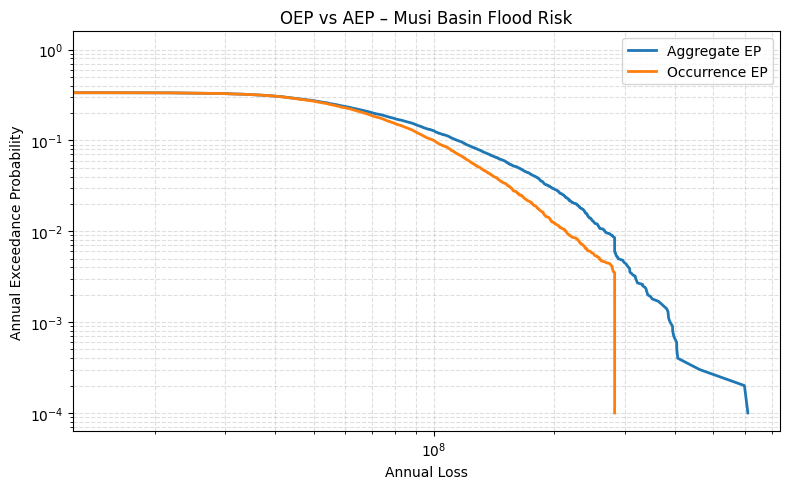

In [33]:
plt.figure(figsize=(8, 5))

plt.plot(agg_loss_sorted, agg_ep, label="Aggregate EP", linewidth=2)
plt.plot(occ_loss_sorted, occ_ep, label="Occurrence EP", linewidth=2)

plt.xscale("log")
plt.yscale("log")

plt.xlabel("Annual Loss")
plt.ylabel("Annual Exceedance Probability")
plt.title("OEP vs AEP – Musi Basin Flood Risk")

plt.grid(True, which="both", linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()


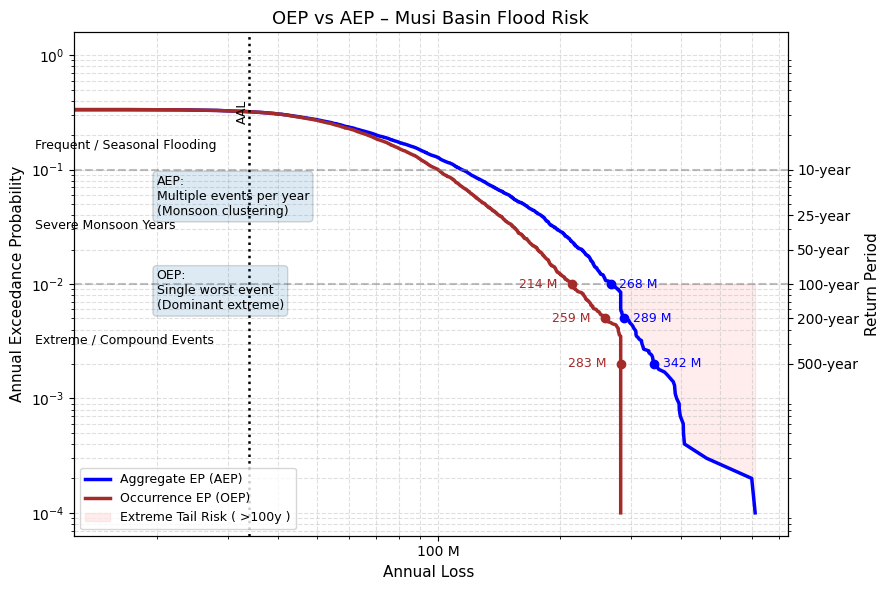

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# -------------------------------
# Helper: PML extractor
# -------------------------------
def pml(losses, ep, target_ep):
    idx = np.argmin(np.abs(ep - target_ep))
    return losses[idx]

# -------------------------------
# Key Risk Metrics
# -------------------------------
AAL = np.mean(annual_aggregate_losses)

PML_LEVELS = {
    "100y": 0.01,
    "200y": 0.005,
    "500y": 0.002
}

agg_pmls = {k: pml(agg_loss_sorted, agg_ep, v) for k, v in PML_LEVELS.items()}
occ_pmls = {k: pml(occ_loss_sorted, occ_ep, v) for k, v in PML_LEVELS.items()}

# -------------------------------
# Plot
# -------------------------------
fig, ax = plt.subplots(figsize=(9, 6))

# Main curves
ax.plot(
    agg_loss_sorted, agg_ep,
    label="Aggregate EP (AEP)",
    linewidth=2.5,
    color="blue"
)

ax.plot(
    occ_loss_sorted, occ_ep,
    label="Occurrence EP (OEP)",
    linewidth=2.5,
    color="brown"
)

# Log scales
ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("Annual Loss ", fontsize=11)
ax.set_ylabel("Annual Exceedance Probability", fontsize=11)
ax.set_title("OEP vs AEP – Musi Basin Flood Risk", fontsize=13)

# -------------------------------
# X-axis formatter: 10^8 → 100 M
# -------------------------------
def million_formatter(x, pos):
    return f"{int(x / 1e6)} M"

ax.xaxis.set_major_formatter(FuncFormatter(million_formatter))

# -------------------------------
# Secondary Y-axis: Return Period
# -------------------------------
ax2 = ax.twinx()

return_periods = np.array([10, 25, 50, 100, 200, 500])
aep_ticks = 1 / return_periods

ax2.set_yscale("log")
ax2.set_ylim(ax.get_ylim())
ax2.set_yticks(aep_ticks)
ax2.set_yticklabels([f"{rp}-year" for rp in return_periods])
ax2.set_ylabel("Return Period", fontsize=11)

# -------------------------------
# Average Annual Loss
# -------------------------------
ax.axvline(AAL, color="black", linestyle=":", linewidth=1.8)
ax.text(
    AAL, 0.25,
    "AAL",
    rotation=90,
    va="bottom",
    ha="right",
    fontsize=9
)

# -------------------------------
# PML markers (LOSS VALUES ONLY)
# -------------------------------
for label, ep in PML_LEVELS.items():

    # Aggregate (AEP)
    loss_aep = agg_pmls[label]
    ax.scatter(loss_aep, ep, color="blue", zorder=6)
    ax.text(
        loss_aep * 1.05,
        ep,
        f"{loss_aep/1e6:.0f} M",
        fontsize=9,
        color="blue",
        va="center"
    )

    # Occurrence (OEP)
    loss_oep = occ_pmls[label]
    ax.scatter(loss_oep, ep, color="brown", zorder=6)
    ax.text(
        loss_oep * 0.92,
        ep,
        f"{loss_oep/1e6:.0f} M",
        fontsize=9,
        color="brown",
        va="center",
        ha="right"
    )

# -------------------------------
# Tail Risk Shading (EP < 1%)
# -------------------------------
ax.fill_betweenx(
    agg_ep,
    agg_loss_sorted,
    max(agg_loss_sorted),
    where=(agg_ep < 0.01),
    color="red",
    alpha=0.07,
    label="Extreme Tail Risk ( >100y )"
)

# -------------------------------
# Risk Regime Bands
# -------------------------------
ax.axhline(0.1, color="grey", linestyle="--", alpha=0.5)
ax.axhline(0.01, color="grey", linestyle="--", alpha=0.5)

ax.text(1e7, 0.15, "Frequent / Seasonal Flooding", fontsize=9)
ax.text(1e7, 0.03, "Severe Monsoon Years", fontsize=9)
ax.text(1e7, 0.003, "Extreme / Compound Events", fontsize=9)

# -------------------------------
# OEP vs AEP Explanation Boxes
# -------------------------------
ax.text(
    2e7, 4e-2,
    "AEP:\nMultiple events per year\n(Monsoon clustering)",
    fontsize=9,
    bbox=dict(boxstyle="round", alpha=0.15)
)

ax.text(
    2e7, 6e-3,
    "OEP:\nSingle worst event\n(Dominant extreme)",
    fontsize=9,
    bbox=dict(boxstyle="round", alpha=0.15)
)

# -------------------------------
# Grid & Legend
# -------------------------------
ax.grid(True, which="both", linestyle="--", alpha=0.4)
ax.legend(loc="lower left", fontsize=9)

plt.tight_layout()
plt.show()


----

### EVT vs Monte Carlo

#### EVT vs Monte Carlo Consistency (1D)

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# LOAD EVT PORTFOLIO LOSSES
# ============================================================

evt = pd.read_csv(
    "/vol/sandeep_storage/Files2/catastrophe/musi_portfolio_loss_evt.csv"
)

evt = evt.sort_values("return_period_years")
evt["ep"] = 1 / evt["return_period_years"]

print(evt)


   return_period_years  portfolio_loss    ep
0                    2    8.781116e+07  0.50
1                    5    1.311051e+08  0.20
2                   10    1.650266e+08  0.10
3                   25    2.145842e+08  0.04
4                   50    2.566871e+08  0.02
5                  100    3.034495e+08  0.01


In [36]:
# ============================================================
# MONTE CARLO EP CURVE (AGGREGATE)
# ============================================================

agg_losses = np.array(annual_aggregate_losses)

mc_loss_sorted = np.sort(agg_losses)[::-1]
mc_ep = np.arange(1, len(mc_loss_sorted) + 1) / (len(mc_loss_sorted) + 1)


In [37]:
# ============================================================
# MC LOSS AT EVT RETURN PERIODS
# ============================================================

mc_evt_compare = []

for _, row in evt.iterrows():
    target_ep = row["ep"]
    idx = np.argmin(np.abs(mc_ep - target_ep))
    
    mc_evt_compare.append({
        "return_period": row["return_period_years"],
        "evt_loss": row["portfolio_loss"],
        "mc_loss": mc_loss_sorted[idx]
    })

compare_df = pd.DataFrame(mc_evt_compare)
compare_df["mc_evt_ratio"] = compare_df["mc_loss"] / compare_df["evt_loss"]

print(compare_df)


   return_period      evt_loss       mc_loss  mc_evt_ratio
0            2.0  8.781116e+07  0.000000e+00      0.000000
1            5.0  1.311051e+08  7.023178e+07      0.535691
2           10.0  1.650266e+08  1.141921e+08      0.691962
3           25.0  2.145842e+08  1.793712e+08      0.835901
4           50.0  2.566871e+08  2.268510e+08      0.883765
5          100.0  3.034495e+08  2.677330e+08      0.882298


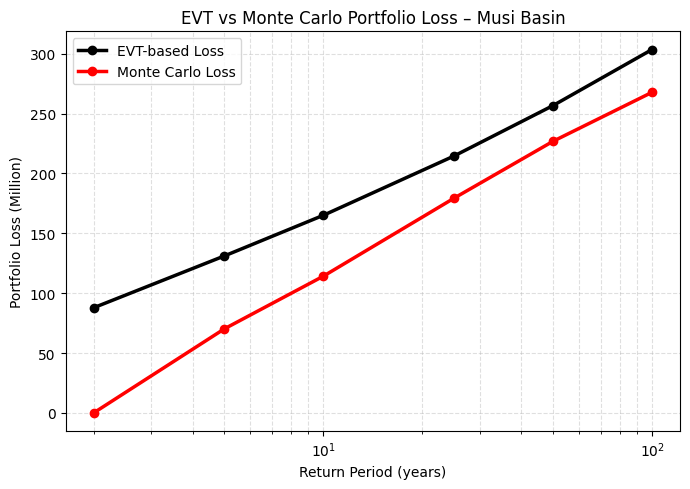

In [38]:
plt.figure(figsize=(7, 5))

plt.plot(
    evt["return_period_years"],
    evt["portfolio_loss"] / 1e6,
    marker="o",
    linewidth=2.5,
    label="EVT-based Loss",
    color="black"
)

plt.plot(
    compare_df["return_period"],
    compare_df["mc_loss"] / 1e6,
    marker="o",
    linewidth=2.5,
    label="Monte Carlo Loss",
    color="red"
)

plt.xscale("log")
plt.xlabel("Return Period (years)")
plt.ylabel("Portfolio Loss (Million)")
plt.title("EVT vs Monte Carlo Portfolio Loss – Musi Basin")

plt.grid(True, which="both", linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()


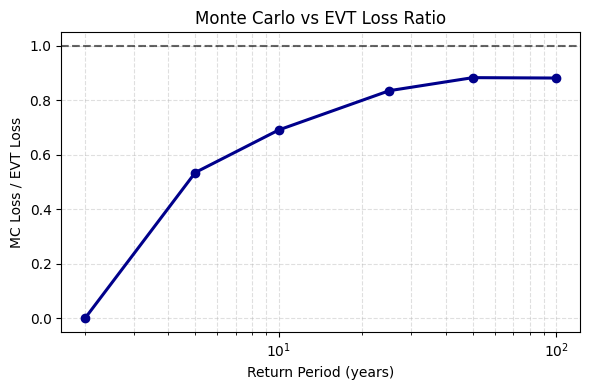

In [39]:
plt.figure(figsize=(6, 4))

plt.plot(
    compare_df["return_period"],
    compare_df["mc_evt_ratio"],
    marker="o",
    linewidth=2.2,
    color="darkblue"
)

plt.axhline(1.0, color="black", linestyle="--", alpha=0.6)

plt.xscale("log")
plt.xlabel("Return Period (years)")
plt.ylabel("MC Loss / EVT Loss")
plt.title("Monte Carlo vs EVT Loss Ratio")

plt.grid(True, which="both", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


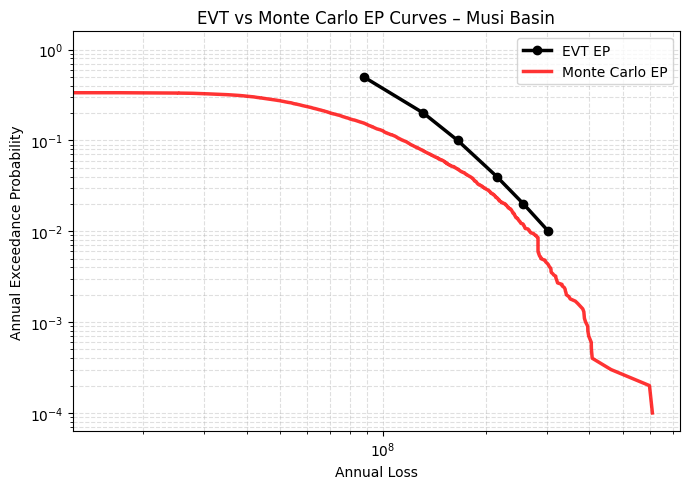

In [40]:
plt.figure(figsize=(7, 5))

# EVT EP curve
plt.plot(
    evt["portfolio_loss"],
    evt["ep"],
    marker="o",
    linewidth=2.5,
    label="EVT EP",
    color="black"
)

# Monte Carlo EP curve
plt.plot(
    mc_loss_sorted,
    mc_ep,
    linewidth=2.5,
    label="Monte Carlo EP",
    color="red",
    alpha=0.8
)

plt.xscale("log")
plt.yscale("log")

plt.xlabel("Annual Loss")
plt.ylabel("Annual Exceedance Probability")
plt.title("EVT vs Monte Carlo EP Curves – Musi Basin")

plt.grid(True, which="both", linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()


In [41]:
print("\n=== EVT vs Monte Carlo CONSISTENCY TABLE ===\n")
print(compare_df.round(3))



=== EVT vs Monte Carlo CONSISTENCY TABLE ===

   return_period      evt_loss       mc_loss  mc_evt_ratio
0            2.0  8.781116e+07  0.000000e+00         0.000
1            5.0  1.311051e+08  7.023178e+07         0.536
2           10.0  1.650266e+08  1.141921e+08         0.692
3           25.0  2.145842e+08  1.793712e+08         0.836
4           50.0  2.566871e+08  2.268510e+08         0.884
5          100.0  3.034495e+08  2.677330e+08         0.882


#### Spatial Risk Mapping (EVT vs MC)

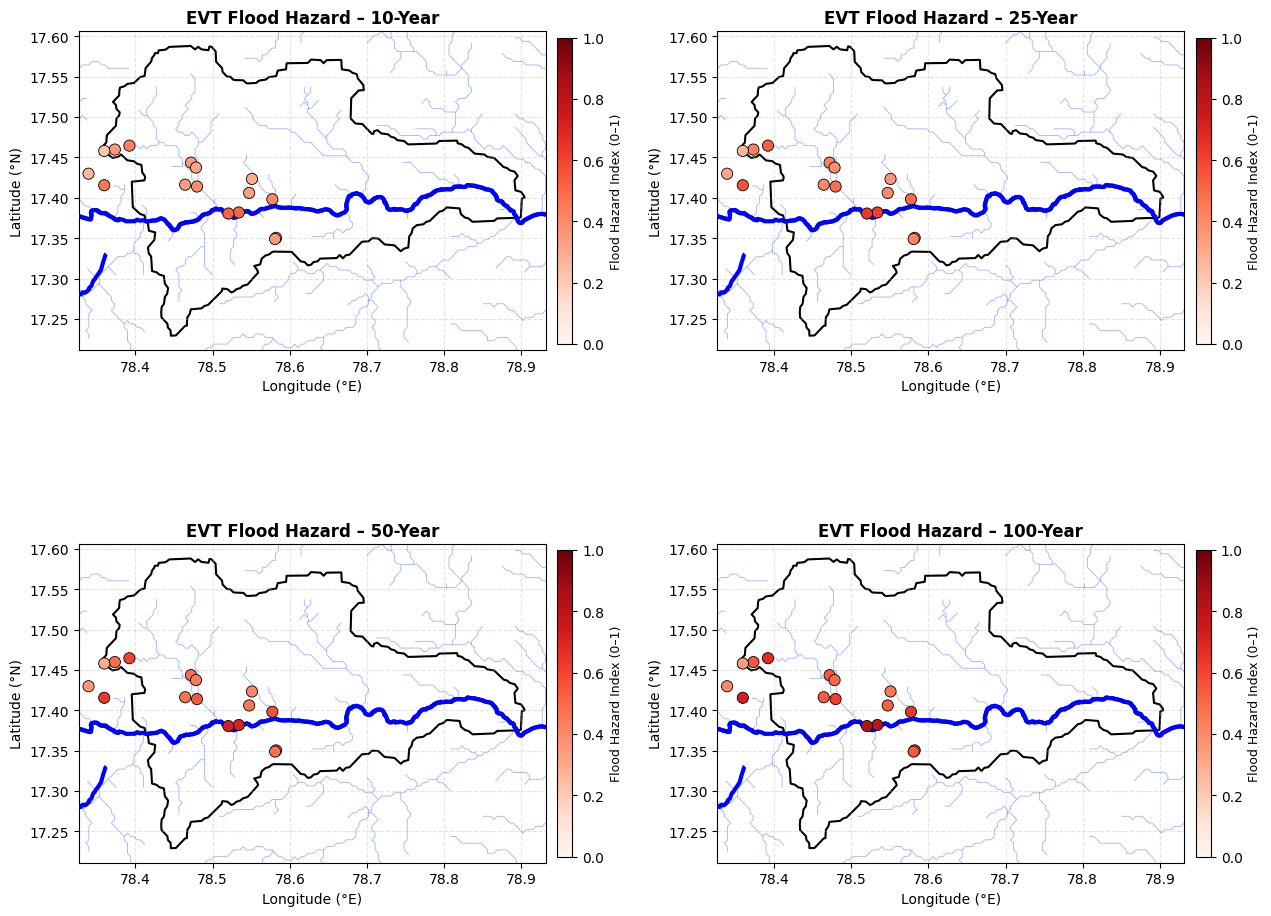

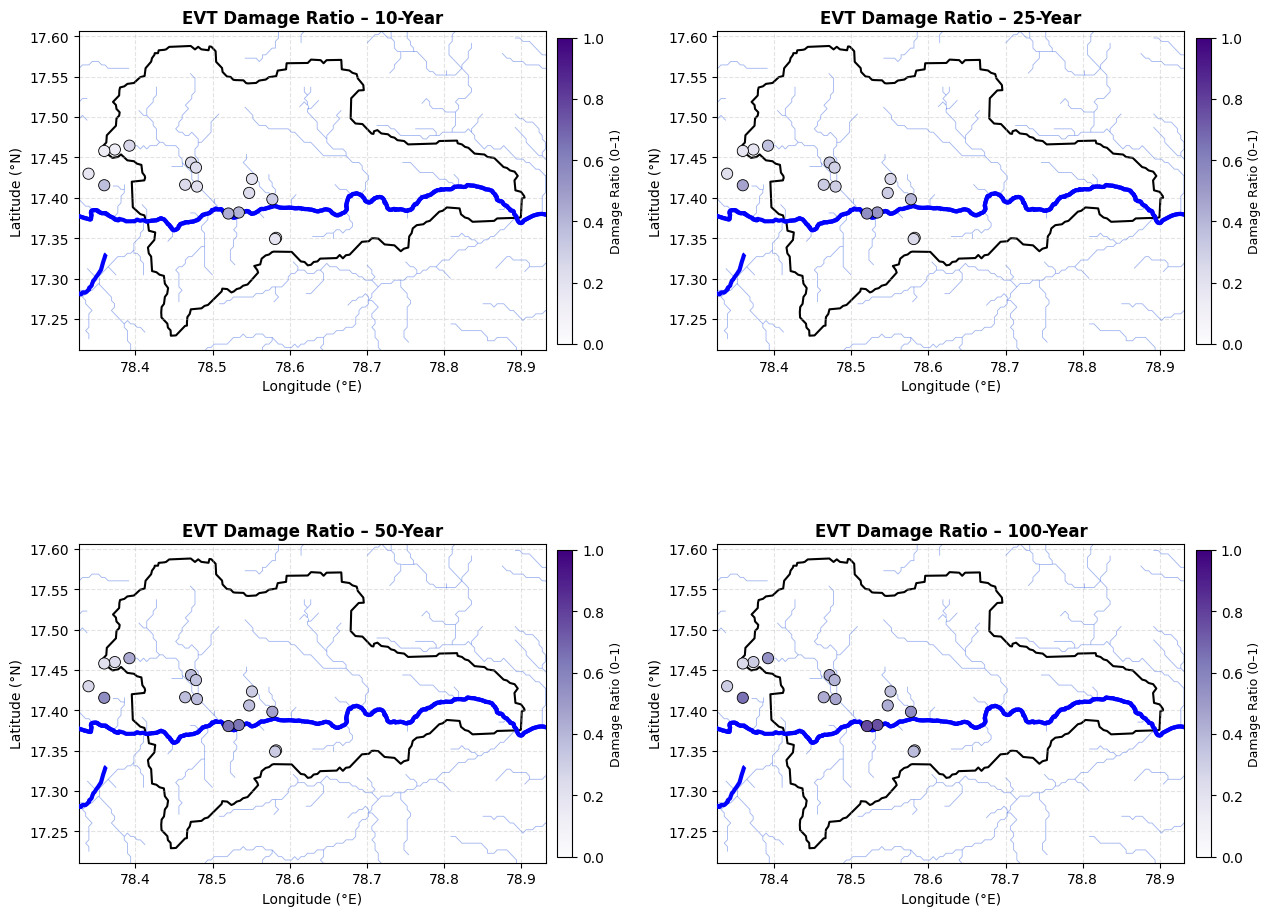

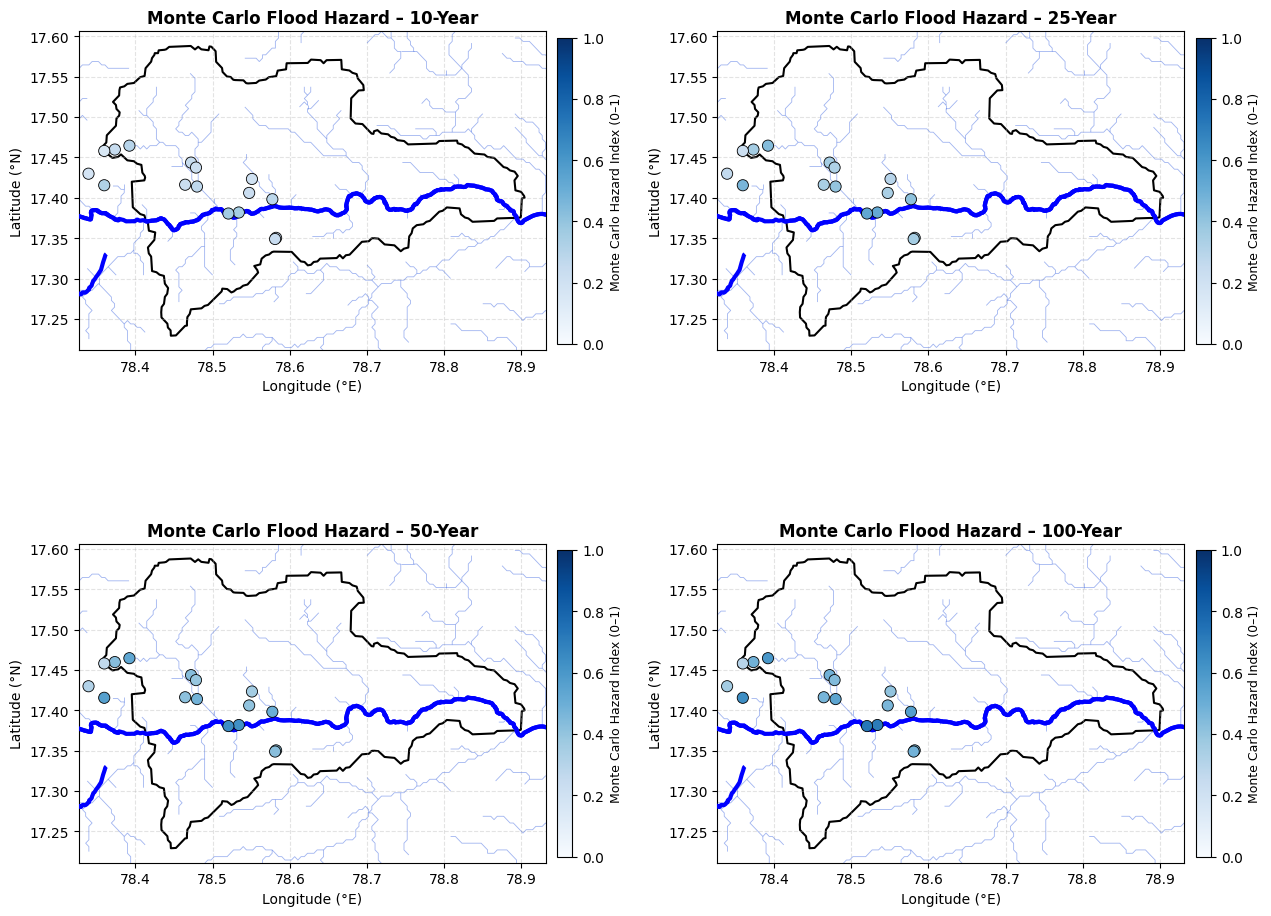

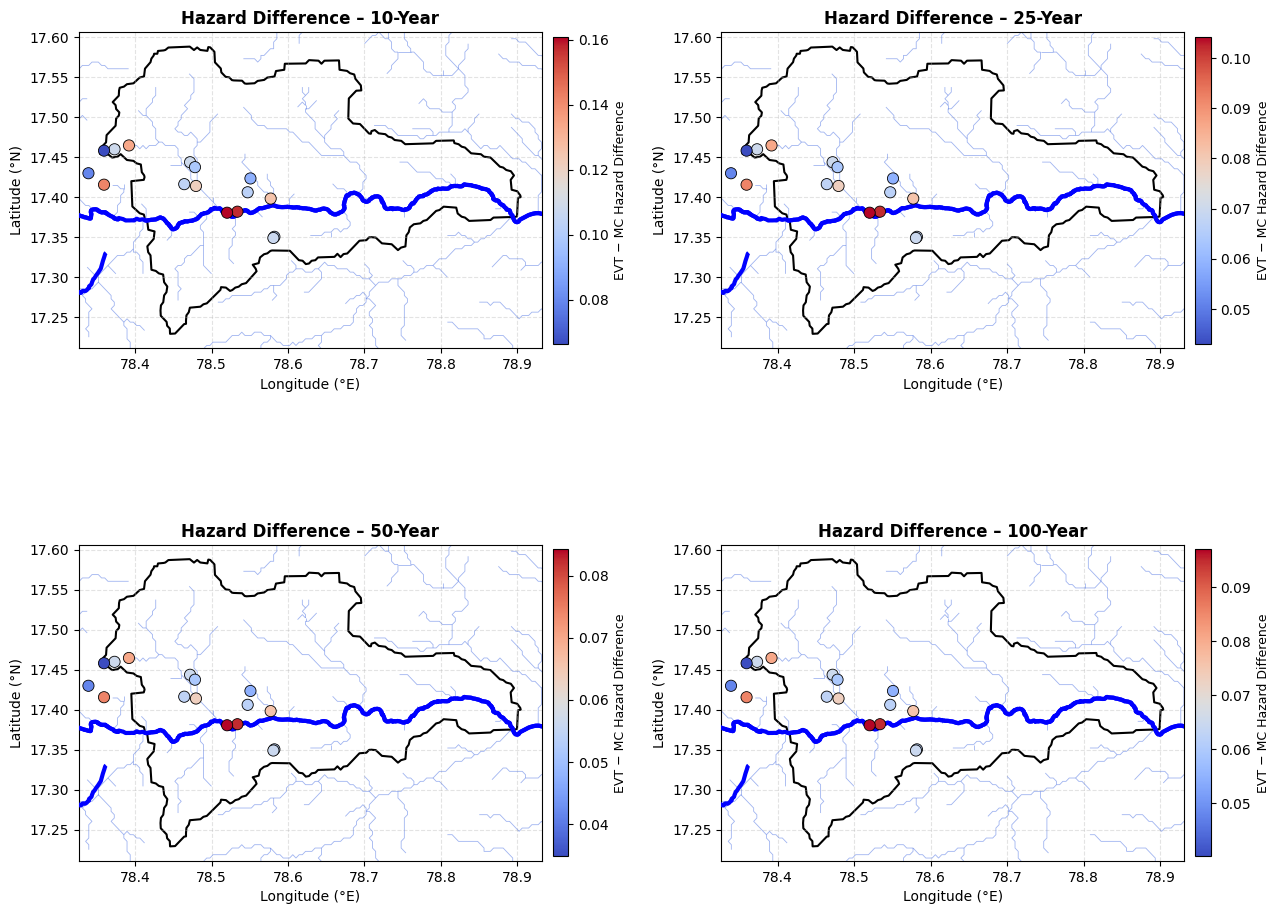

In [50]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
import numpy as np

# ============================================================
# LOAD DATA
# ============================================================

haz_evt = gpd.read_file(
    "/vol/sandeep_storage/Files2/catastrophe/osm/"
    "waste_facilities_flood_hazard_scenarios_evt.geojson"
).to_crs(epsg=4326)

dam_evt = gpd.read_file(
    "/vol/sandeep_storage/Files2/catastrophe/osm/"
    "waste_facilities_damage_scenarios_evt.geojson"
).to_crs(epsg=4326)

basin = gpd.read_file(
    "/vol/sandeep_storage/Files2/catastrophe/hydrobasin_08/musi_basin.shp"
).to_crs(epsg=4326)

rivers = gpd.read_file(
    "/vol/sandeep_storage/Files2/catastrophe/hydrorivers/"
    "hydrorivers_clean.geojson"
).to_crs(epsg=4326)

musi = gpd.read_file(
    "/vol/sandeep_storage/Files2/catastrophe/hydrorivers/"
    "musi.geojson"
).to_crs(epsg=4326)

# ============================================================
# MAP EXTENT
# ============================================================

minx, miny, maxx, maxy = basin.total_bounds
padx = 0.05 * (maxx - minx)
pady = 0.05 * (maxy - miny)

extent = [minx-padx, maxx+padx, miny-pady, maxy+pady]

# ============================================================
# COMMON MAP FUNCTION
# ============================================================

def base_map(ax):
    basin.boundary.plot(ax=ax, color="black", linewidth=1.5, zorder=1)
    rivers.plot(ax=ax, color="royalblue", linewidth=0.6, alpha=0.5, zorder=2)
    musi.plot(ax=ax, color="blue", linewidth=3, zorder=3)
    ax.set_xlim(extent[0], extent[1])
    ax.set_ylim(extent[2], extent[3])
    ax.set_xlabel("Longitude (°E)")
    ax.set_ylabel("Latitude (°N)")
    ax.grid(True, linestyle="--", alpha=0.35)

# ============================================================
# EVT HAZARD MAPS
# ============================================================

rps = [10, 25, 50, 100]

fig, axes = plt.subplots(2, 2, figsize=(13, 11))
axes = axes.flatten()

for ax, rp in zip(axes, rps):
    base_map(ax)

    norm = mpl.colors.Normalize(0, 1)

    sc = ax.scatter(
        haz_evt.geometry.x,
        haz_evt.geometry.y,
        c=haz_evt[f"hazard_{rp}yr"],
        cmap="Reds",
        norm=norm,
        s=65,
        edgecolor="black",
        linewidth=0.6,
        zorder=4
    )

    cbar = plt.colorbar(sc, ax=ax, shrink=0.55, pad=0.02)
    cbar.set_label("Flood Hazard Index (0–1)", fontsize=9)

    ax.set_title(f"EVT Flood Hazard – {rp}-Year", fontsize=12, weight="bold")

plt.tight_layout()
plt.show()

# ============================================================
# EVT DAMAGE MAPS
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(13, 11))
axes = axes.flatten()

for ax, rp in zip(axes, rps):
    base_map(ax)

    sc = ax.scatter(
        dam_evt.geometry.x,
        dam_evt.geometry.y,
        c=dam_evt[f"damage_{rp}yr"],
        cmap="Purples",
        vmin=0,
        vmax=1,
        s=65,
        edgecolor="black",
        linewidth=0.6,
        zorder=4
    )

    cbar = plt.colorbar(sc, ax=ax, shrink=0.55, pad=0.02)
    cbar.set_label("Damage Ratio (0–1)", fontsize=9)

    ax.set_title(f"EVT Damage Ratio – {rp}-Year", fontsize=12, weight="bold")

plt.tight_layout()
plt.show()

# ============================================================
# MONTE CARLO HAZARD (SCALED)
# ============================================================

MC_EVT_RATIO = {
    10: 0.692,
    25: 0.836,
    50: 0.884,
    100: 0.882
}

for rp, ratio in MC_EVT_RATIO.items():
    haz_evt[f"hazard_mc_{rp}yr"] = (
        haz_evt[f"hazard_{rp}yr"] * ratio
    ).clip(0, 1)

fig, axes = plt.subplots(2, 2, figsize=(13, 11))
axes = axes.flatten()

for ax, rp in zip(axes, rps):
    base_map(ax)

    sc = ax.scatter(
        haz_evt.geometry.x,
        haz_evt.geometry.y,
        c=haz_evt[f"hazard_mc_{rp}yr"],
        cmap="Blues",
        vmin=0,
        vmax=1,
        s=65,
        edgecolor="black",
        linewidth=0.6,
        zorder=4
    )

    cbar = plt.colorbar(sc, ax=ax, shrink=0.55, pad=0.02)
    cbar.set_label("Monte Carlo Hazard Index (0–1)", fontsize=9)

    ax.set_title(f"Monte Carlo Flood Hazard – {rp}-Year", fontsize=12, weight="bold")

plt.tight_layout()
plt.show()

# ============================================================
# EVT − MONTE CARLO DIFFERENCE MAPS
# ============================================================

for rp in rps:
    haz_evt[f"hazard_diff_{rp}yr"] = (
        haz_evt[f"hazard_{rp}yr"] - haz_evt[f"hazard_mc_{rp}yr"]
    )

fig, axes = plt.subplots(2, 2, figsize=(13, 11))
axes = axes.flatten()

for ax, rp in zip(axes, rps):
    base_map(ax)

    sc = ax.scatter(
        haz_evt.geometry.x,
        haz_evt.geometry.y,
        c=haz_evt[f"hazard_diff_{rp}yr"],
        cmap="coolwarm",
        s=65,
        edgecolor="black",
        linewidth=0.6,
        zorder=4
    )

    cbar = plt.colorbar(sc, ax=ax, shrink=0.55, pad=0.02)
    cbar.set_label("EVT − MC Hazard Difference", fontsize=9)

    ax.set_title(f"Hazard Difference – {rp}-Year", fontsize=12, weight="bold")

plt.tight_layout()
plt.show()


In [52]:
cols = []
for rp in rps:
    cols.extend([
        f"hazard_{rp}yr",
        f"hazard_mc_{rp}yr",
        f"hazard_diff_{rp}yr"
    ])

print(haz_evt[cols].describe())


       hazard_10yr  hazard_mc_10yr  hazard_diff_10yr  hazard_25yr  \
count    16.000000       16.000000         16.000000    16.000000   
mean      0.367121        0.254048          0.113073     0.446591   
std       0.084326        0.058353          0.025972     0.102580   
min       0.216193        0.149606          0.066587     0.262992   
25%       0.330122        0.228444          0.101677     0.401582   
50%       0.349449        0.241819          0.107630     0.425094   
75%       0.414752        0.287008          0.127744     0.504532   
max       0.522219        0.361375          0.160843     0.635262   

       hazard_mc_25yr  hazard_diff_25yr  hazard_50yr  hazard_mc_50yr  \
count       16.000000         16.000000    16.000000       16.000000   
mean         0.373350          0.073241     0.510304        0.451109   
std          0.085757          0.016823     0.117214        0.103617   
min          0.219861          0.043131     0.300512        0.265652   
25%          0.335

#### Spatial Loss & Risk Mapping

In [53]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

# ============================================================
# LOAD DATA
# ============================================================

dam = gpd.read_file(
    "/vol/sandeep_storage/Files2/catastrophe/osm/"
    "waste_facilities_damage_scenarios_evt.geojson"
).to_crs(epsg=4326)

basin = gpd.read_file(
    "/vol/sandeep_storage/Files2/catastrophe/hydrobasin_08/"
    "musi_basin.shp"
).to_crs(epsg=4326)

rivers = gpd.read_file(
    "/vol/sandeep_storage/Files2/catastrophe/hydrorivers/"
    "hydrorivers_clean.geojson"
).to_crs(epsg=4326)

musi = gpd.read_file(
    "/vol/sandeep_storage/Files2/catastrophe/hydrorivers/"
    "musi.geojson"
).to_crs(epsg=4326)


In [54]:
ASSET_VALUE = {
    "wastewater_plant": 5e7,
    "landfill": 2e7,
    "transfer_station": 1.5e7,
    "recycling": 1e7,
    "other": 1e7
}

dam["asset_value"] = dam["facility_type"].map(ASSET_VALUE).fillna(1e7)


In [55]:
rps = [10, 25, 50, 100]

for rp in rps:
    dam[f"loss_evt_{rp}yr"] = (
        dam[f"damage_{rp}yr"] * dam["asset_value"]
    )


In [56]:
MC_EVT_RATIO = {
    10: 0.692,
    25: 0.836,
    50: 0.884,
    100: 0.882
}

for rp, ratio in MC_EVT_RATIO.items():
    dam[f"loss_mc_{rp}yr"] = (
        dam[f"loss_evt_{rp}yr"] * ratio
    )


In [57]:
minx, miny, maxx, maxy = basin.total_bounds
padx = 0.05 * (maxx - minx)
pady = 0.05 * (maxy - miny)
extent = [minx-padx, maxx+padx, miny-pady, maxy+pady]

def base_map(ax):
    basin.boundary.plot(ax=ax, color="black", linewidth=1.5, zorder=1)
    rivers.plot(ax=ax, color="royalblue", linewidth=0.6, alpha=0.5, zorder=2)
    musi.plot(ax=ax, color="blue", linewidth=3, zorder=3)
    ax.set_xlim(extent[0], extent[1])
    ax.set_ylim(extent[2], extent[3])
    ax.set_xlabel("Longitude (°E)")
    ax.set_ylabel("Latitude (°N)")
    ax.grid(True, linestyle="--", alpha=0.35)


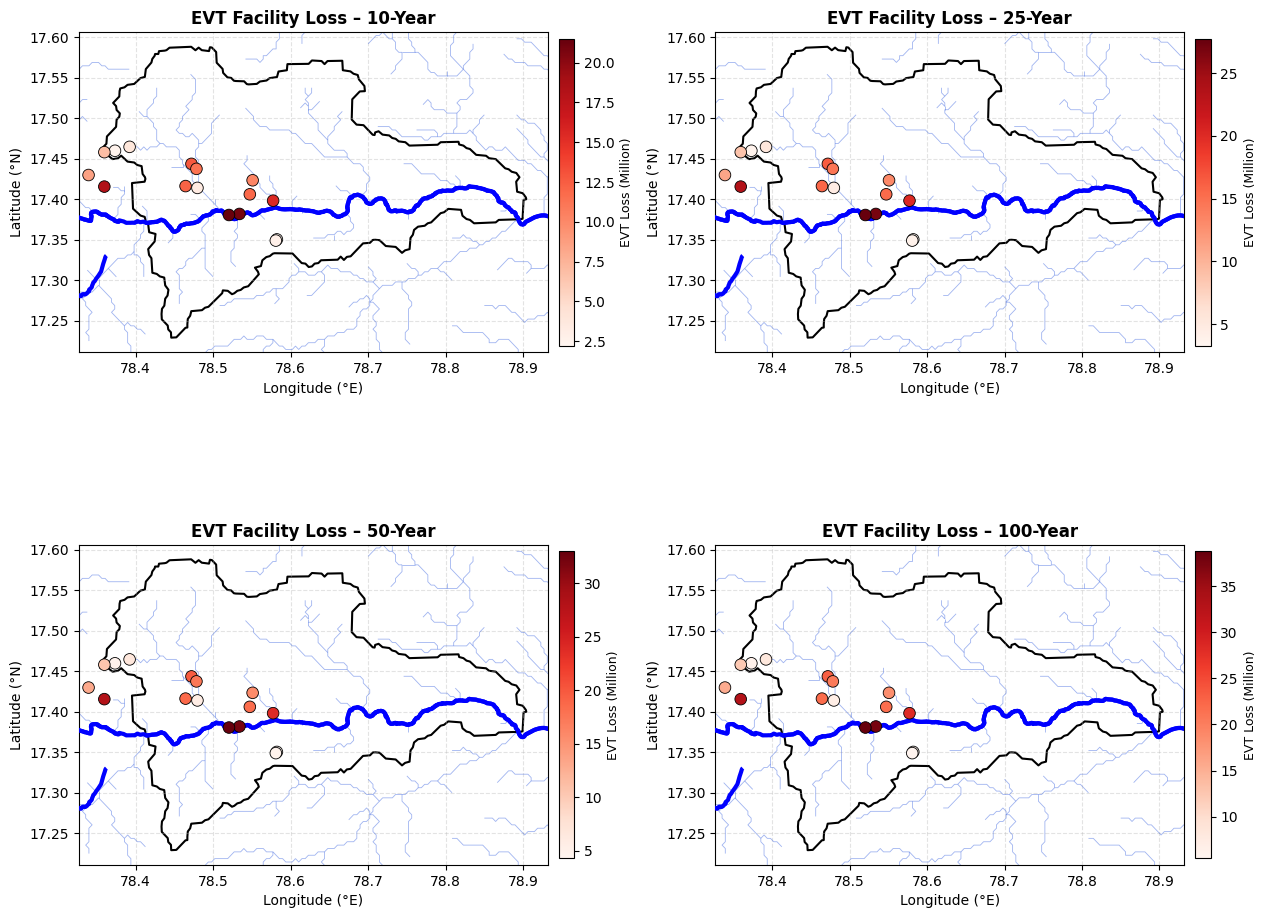

In [58]:
fig, axes = plt.subplots(2, 2, figsize=(13, 11))
axes = axes.flatten()

for ax, rp in zip(axes, rps):
    base_map(ax)

    sc = ax.scatter(
        dam.geometry.x,
        dam.geometry.y,
        c=dam[f"loss_evt_{rp}yr"] / 1e6,
        cmap="Reds",
        s=70,
        edgecolor="black",
        linewidth=0.6,
        zorder=4
    )

    cbar = plt.colorbar(sc, ax=ax, shrink=0.55, pad=0.02)
    cbar.set_label("EVT Loss (Million)", fontsize=9)

    ax.set_title(f"EVT Facility Loss – {rp}-Year", fontsize=12, weight="bold")

plt.tight_layout()
plt.show()


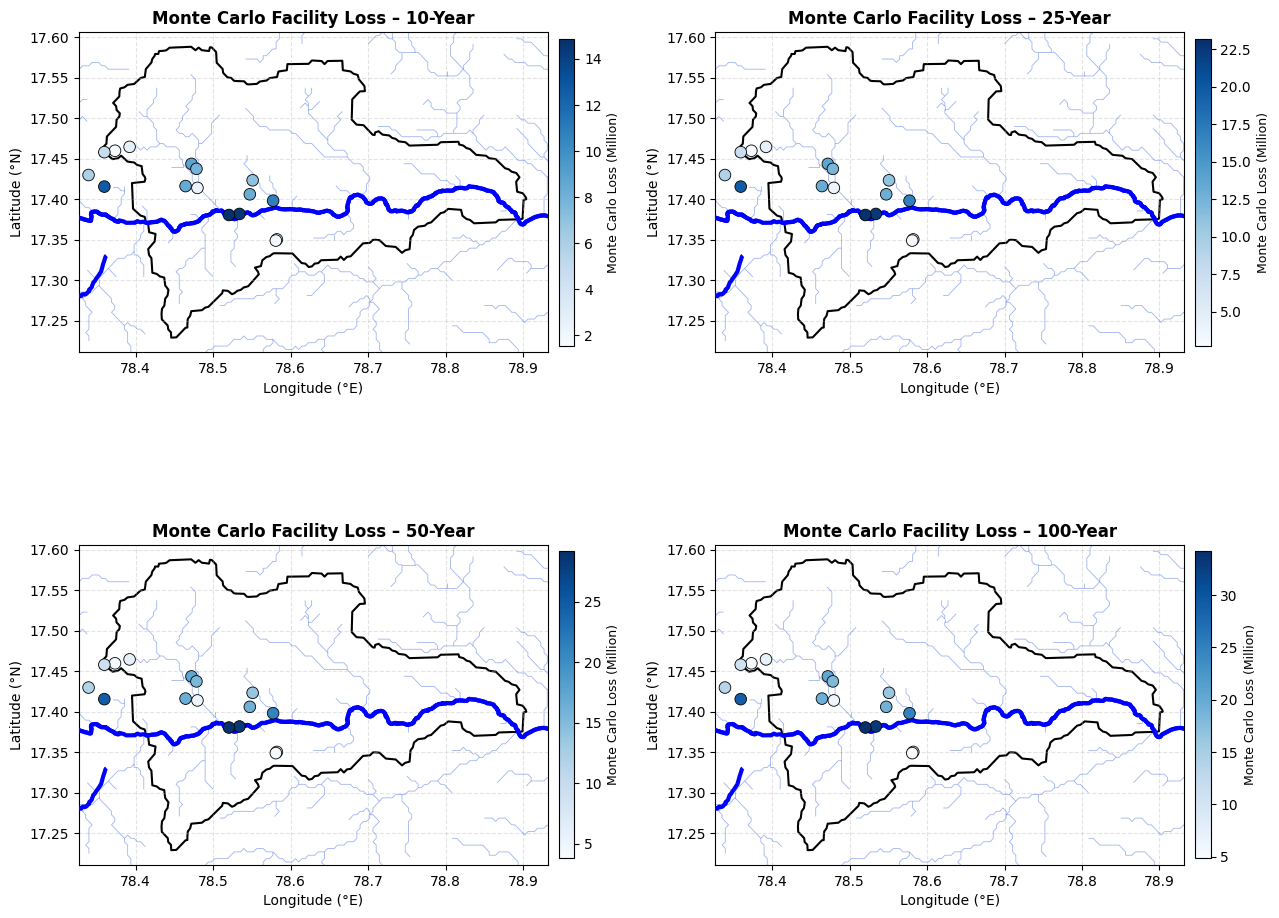

In [59]:
fig, axes = plt.subplots(2, 2, figsize=(13, 11))
axes = axes.flatten()

for ax, rp in zip(axes, rps):
    base_map(ax)

    sc = ax.scatter(
        dam.geometry.x,
        dam.geometry.y,
        c=dam[f"loss_mc_{rp}yr"] / 1e6,
        cmap="Blues",
        s=70,
        edgecolor="black",
        linewidth=0.6,
        zorder=4
    )

    cbar = plt.colorbar(sc, ax=ax, shrink=0.55, pad=0.02)
    cbar.set_label("Monte Carlo Loss (Million)", fontsize=9)

    ax.set_title(f"Monte Carlo Facility Loss – {rp}-Year", fontsize=12, weight="bold")

plt.tight_layout()
plt.show()


In [60]:
for rp in rps:
    dam[f"loss_diff_{rp}yr"] = (
        dam[f"loss_evt_{rp}yr"] - dam[f"loss_mc_{rp}yr"]
    )


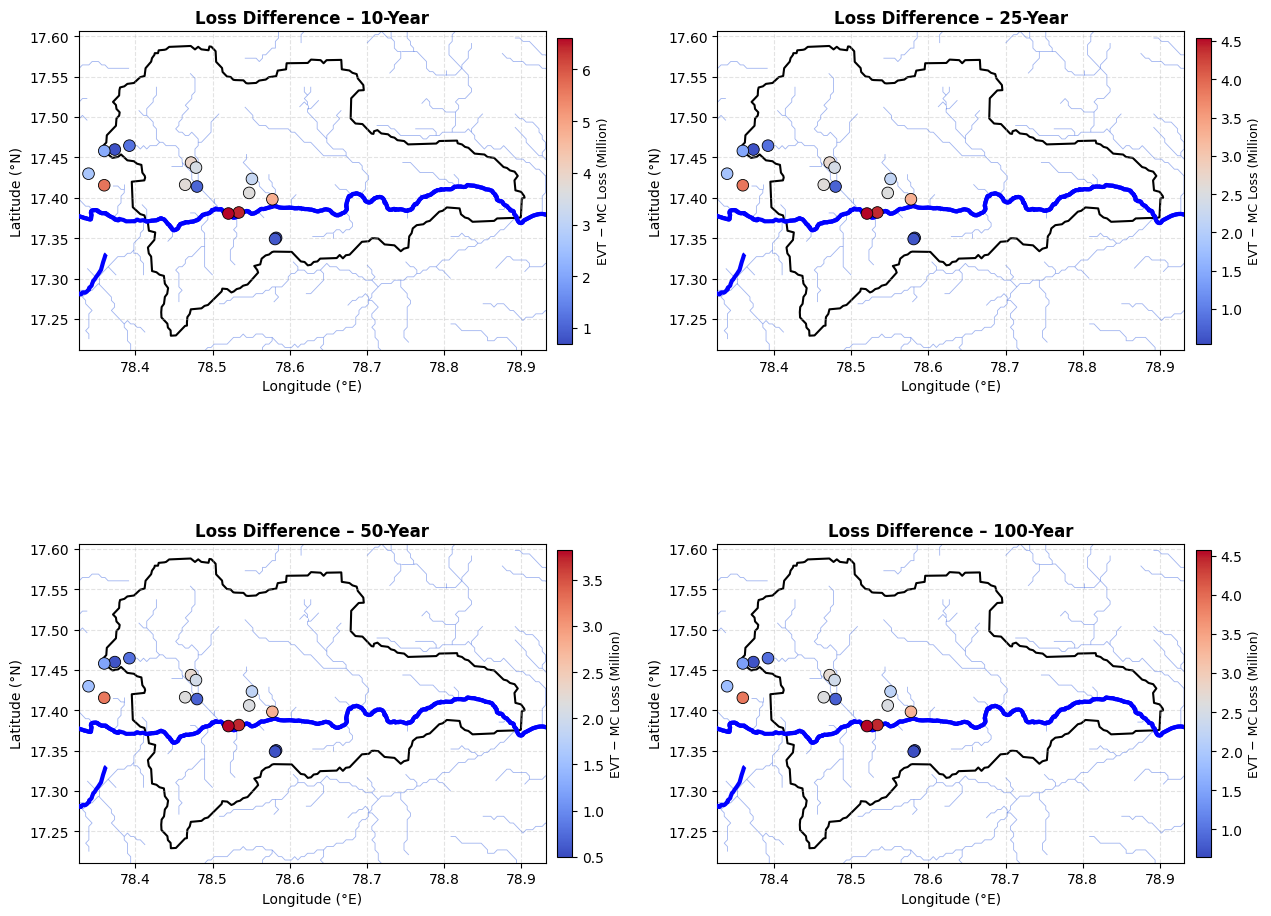

In [61]:
fig, axes = plt.subplots(2, 2, figsize=(13, 11))
axes = axes.flatten()

for ax, rp in zip(axes, rps):
    base_map(ax)

    sc = ax.scatter(
        dam.geometry.x,
        dam.geometry.y,
        c=dam[f"loss_diff_{rp}yr"] / 1e6,
        cmap="coolwarm",
        s=70,
        edgecolor="black",
        linewidth=0.6,
        zorder=4
    )

    cbar = plt.colorbar(sc, ax=ax, shrink=0.55, pad=0.02)
    cbar.set_label("EVT − MC Loss (Million)", fontsize=9)

    ax.set_title(f"Loss Difference – {rp}-Year", fontsize=12, weight="bold")

plt.tight_layout()
plt.show()


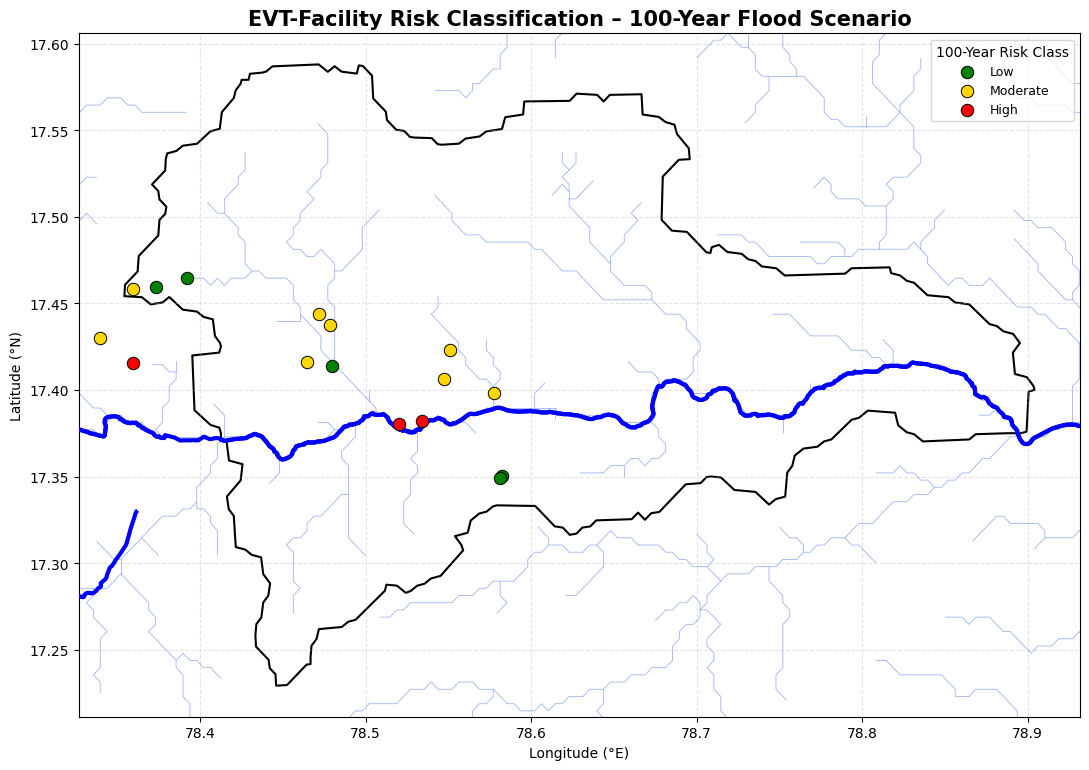

In [70]:
def risk_class(loss):
    if loss < 1e7:
        return "Low"
    elif loss < 3e7:
        return "Moderate"
    else:
        return "High"
    #else:
     #   return "Critical"

dam["risk_class_100yr"] = dam["loss_evt_100yr"].apply(risk_class)

color_map = {
    "Low": "green",
    "Moderate": "gold",
    "High": "red",
    #"Critical": "red"
}

fig, ax = plt.subplots(figsize=(11, 9))
base_map(ax)

for cls, color in color_map.items():
    subset = dam[dam["risk_class_100yr"] == cls]
    ax.scatter(
        subset.geometry.x,
        subset.geometry.y,
        color=color,
        s=80,
        edgecolor="black",
        linewidth=0.7,
        label=cls,
        zorder=4
    )

ax.legend(title="100-Year Risk Class", fontsize=9)
ax.set_title(
    "EVT-Facility Risk Classification – 100-Year Flood Scenario",
    fontsize=15,
    weight="bold"
)

plt.tight_layout()
plt.show()


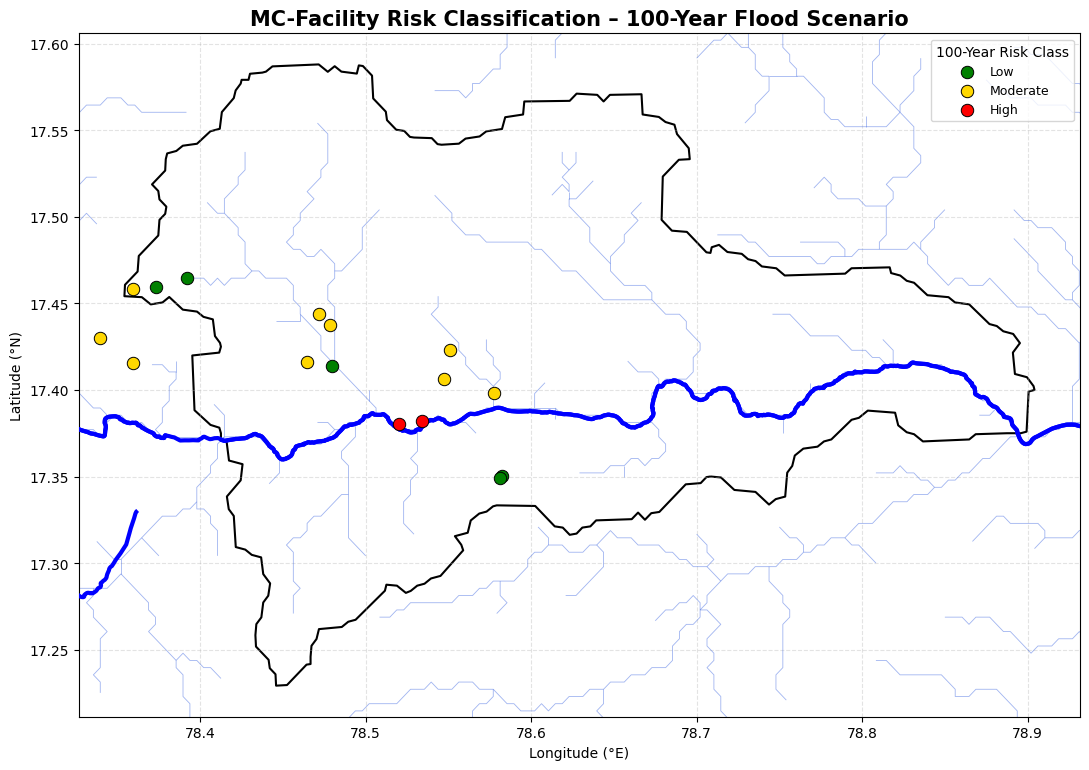

In [69]:
def risk_class(loss):
    if loss < 1e7:
        return "Low"
    elif loss < 3e7:
        return "Moderate"
    else:
        return "High"
    #else:
     #   return "Critical"

dam["risk_class_100yr"] = dam["loss_mc_100yr"].apply(risk_class)

color_map = {
    "Low": "green",
    "Moderate": "gold",
    "High": "red",
    #"Critical": "red"
}

fig, ax = plt.subplots(figsize=(11, 9))
base_map(ax)

for cls, color in color_map.items():
    subset = dam[dam["risk_class_100yr"] == cls]
    ax.scatter(
        subset.geometry.x,
        subset.geometry.y,
        color=color,
        s=80,
        edgecolor="black",
        linewidth=0.7,
        label=cls,
        zorder=4
    )

ax.legend(title="100-Year Risk Class", fontsize=9)
ax.set_title(
    "MC-Facility Risk Classification – 100-Year Flood Scenario",
    fontsize=15,
    weight="bold"
)

plt.tight_layout()
plt.show()


In [71]:
import numpy as np
import pandas as pd
import geopandas as gpd
from scipy.stats import genextreme
import matplotlib.pyplot as plt

# ============================================================
# PARAMETERS (same as your MC notebook)
# ============================================================

MU = 48.47
SIGMA = 15.35
XI = 0.094
SHAPE = -XI

R100 = 136.87
LAMBDA_EVENTS = 0.4
N_YEARS = 10000

ASSET_VALUE = {
    "wastewater_plant": 5e7,
    "landfill": 2e7,
    "transfer_station": 1.5e7,
    "recycling": 1e7,
    "other": 1e7
}
DEFAULT_VALUE = 1e7

# ============================================================
# STORAGE
# ============================================================

n_fac = len(dam)
facility_losses = np.zeros((N_YEARS, n_fac))
annual_total_loss = np.zeros(N_YEARS)

# ============================================================
# MONTE CARLO SIMULATION (FACILITY-LEVEL)
# ============================================================

for y in range(N_YEARS):

    n_events = np.random.poisson(LAMBDA_EVENTS)
    year_fac_loss = np.zeros(n_fac)

    for _ in range(n_events):

        rainfall = genextreme.rvs(SHAPE, loc=MU, scale=SIGMA)
        if rainfall <= 0:
            continue

        event_hazard = min(rainfall / R100, 1.0)

        for i, row in dam.iterrows():

            asset = ASSET_VALUE.get(row["facility_type"], DEFAULT_VALUE)
            fac_hazard = min(row["flood_hazard_index"] * event_hazard, 1.0)
            damage = min(fac_hazard ** 1.5, 1.0)

            year_fac_loss[i] += asset * damage

    facility_losses[y, :] = year_fac_loss
    annual_total_loss[y] = year_fac_loss.sum()


In [72]:
dam["loss_mc_mean"] = facility_losses.mean(axis=0)


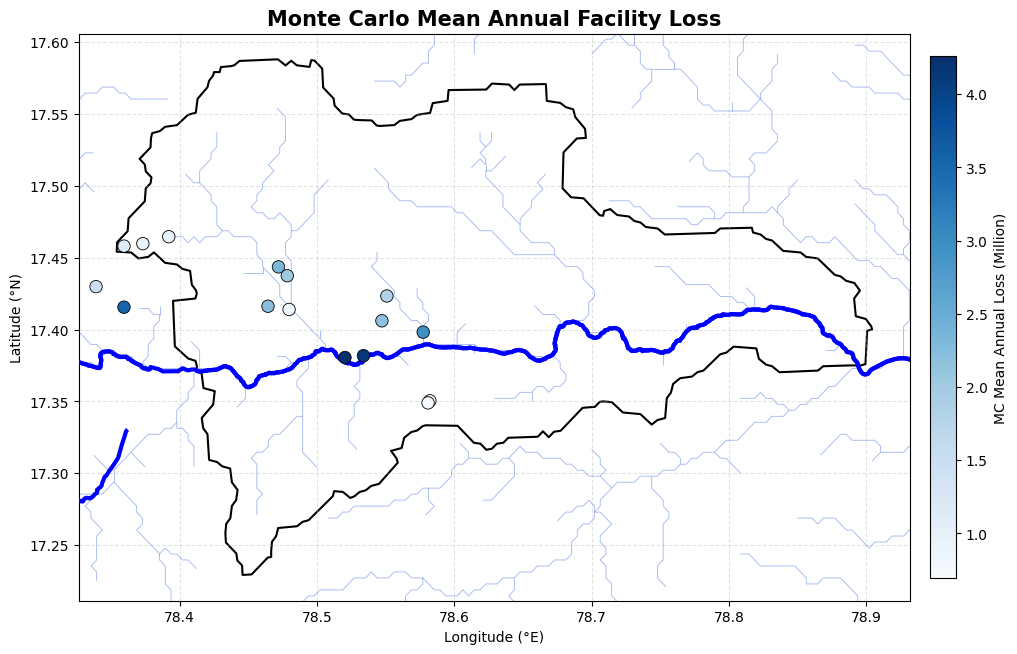

In [73]:
fig, ax = plt.subplots(figsize=(11, 9))
base_map(ax)

sc = ax.scatter(
    dam.geometry.x,
    dam.geometry.y,
    c=dam["loss_mc_mean"] / 1e6,
    cmap="Blues",
    s=80,
    edgecolor="black",
    linewidth=0.6,
    zorder=4
)

cbar = plt.colorbar(sc, ax=ax, shrink=0.6, pad=0.02)
cbar.set_label("MC Mean Annual Loss (Million)", fontsize=10)

ax.set_title("Monte Carlo Mean Annual Facility Loss", fontsize=15, weight="bold")
plt.tight_layout()
plt.show()


In [74]:
# ============================================================
# Identify tail years (EP < 2%)
# ============================================================

threshold = np.percentile(annual_total_loss, 98)
tail_mask = annual_total_loss >= threshold

dam["loss_mc_tail"] = facility_losses[tail_mask].mean(axis=0)


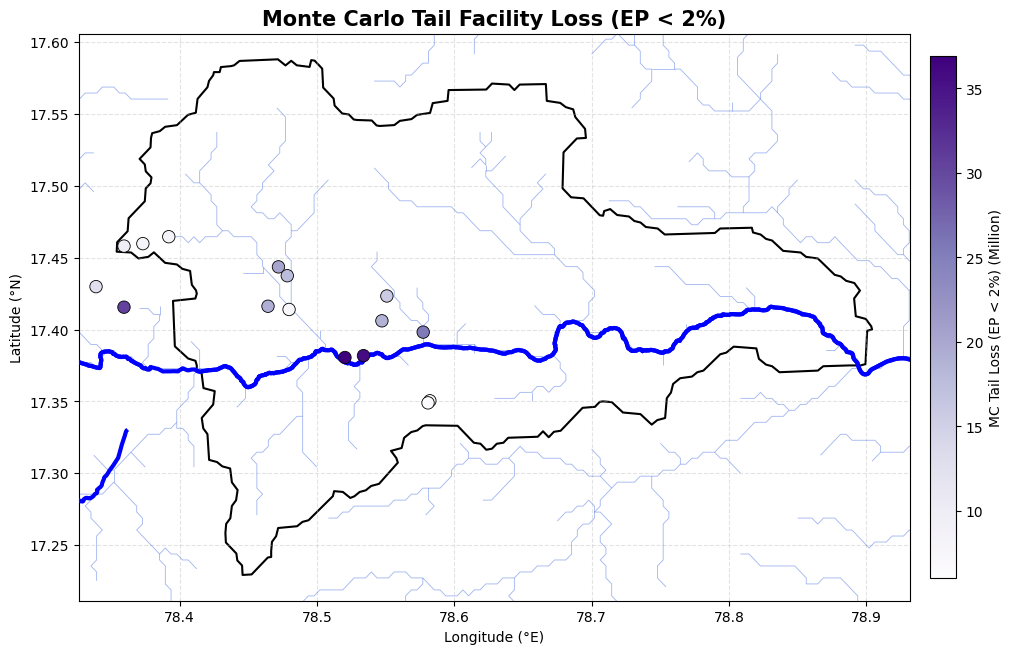

In [75]:
fig, ax = plt.subplots(figsize=(11, 9))
base_map(ax)

sc = ax.scatter(
    dam.geometry.x,
    dam.geometry.y,
    c=dam["loss_mc_tail"] / 1e6,
    cmap="Purples",
    s=80,
    edgecolor="black",
    linewidth=0.6,
    zorder=4
)

cbar = plt.colorbar(sc, ax=ax, shrink=0.6, pad=0.02)
cbar.set_label("MC Tail Loss (EP < 2%) (Million)", fontsize=10)

ax.set_title("Monte Carlo Tail Facility Loss (EP < 2%)", fontsize=15, weight="bold")
plt.tight_layout()
plt.show()


In [76]:
dam["evt_mc_mean_diff"] = dam["loss_evt_100yr"] - dam["loss_mc_mean"]
dam["evt_mc_mean_ratio"] = dam["loss_mc_mean"] / dam["loss_evt_100yr"]


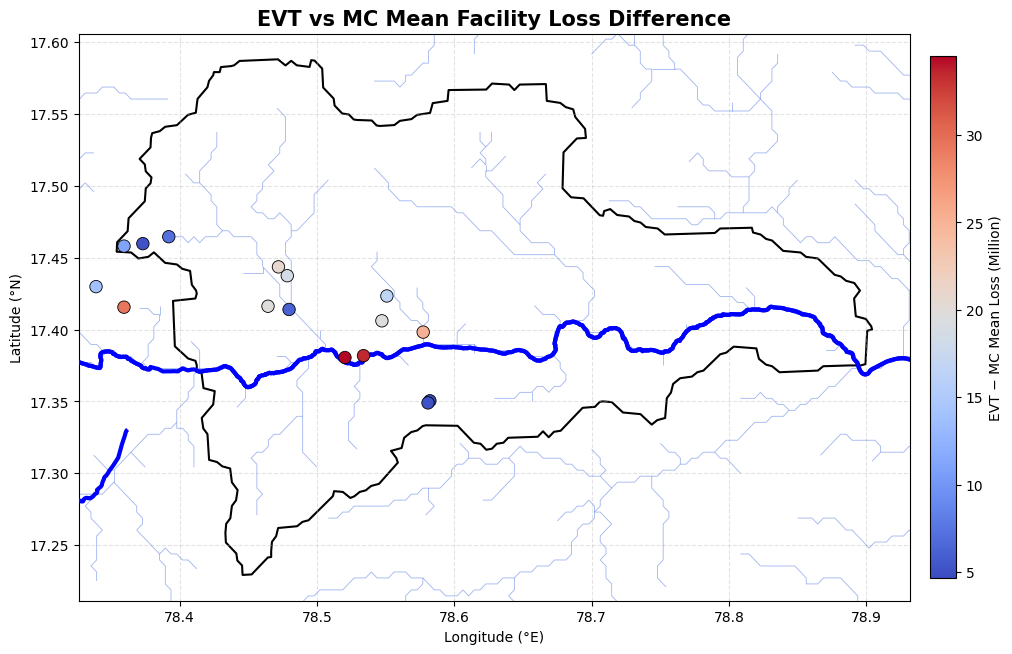

In [77]:
fig, ax = plt.subplots(figsize=(11, 9))
base_map(ax)

sc = ax.scatter(
    dam.geometry.x,
    dam.geometry.y,
    c=dam["evt_mc_mean_diff"] / 1e6,
    cmap="coolwarm",
    s=80,
    edgecolor="black",
    linewidth=0.6,
    zorder=4
)

cbar = plt.colorbar(sc, ax=ax, shrink=0.6, pad=0.02)
cbar.set_label("EVT − MC Mean Loss (Million)", fontsize=10)

ax.set_title("EVT vs MC Mean Facility Loss Difference", fontsize=15, weight="bold")
plt.tight_layout()
plt.show()


In [78]:
dam["evt_mc_tail_diff"] = dam["loss_evt_100yr"] - dam["loss_mc_tail"]
dam["evt_mc_tail_ratio"] = dam["loss_mc_tail"] / dam["loss_evt_100yr"]


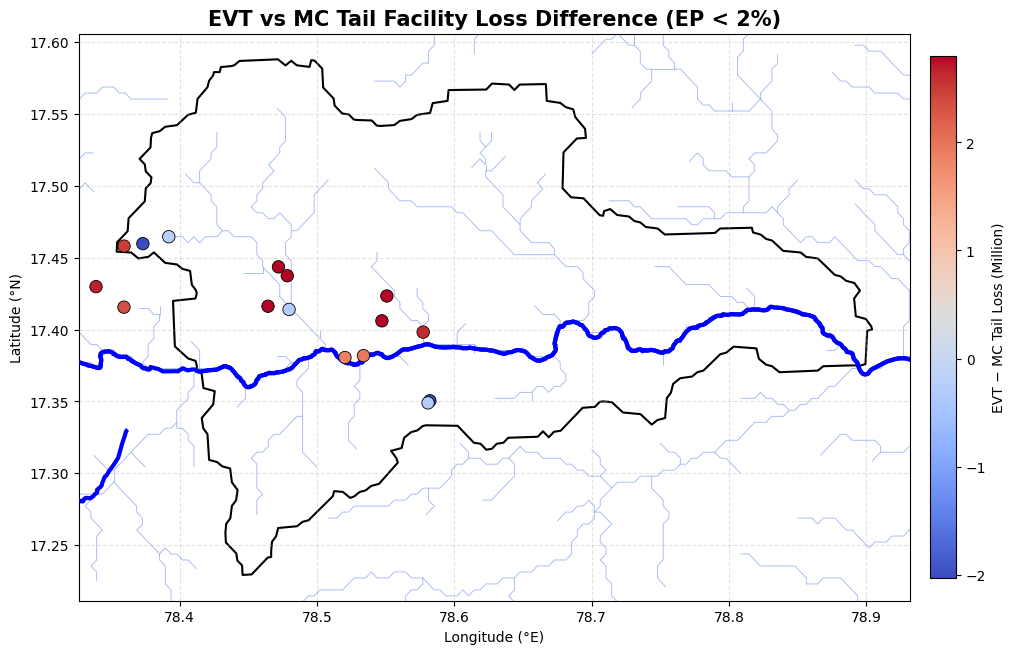

In [79]:
fig, ax = plt.subplots(figsize=(11, 9))
base_map(ax)

sc = ax.scatter(
    dam.geometry.x,
    dam.geometry.y,
    c=dam["evt_mc_tail_diff"] / 1e6,
    cmap="coolwarm",
    s=80,
    edgecolor="black",
    linewidth=0.6,
    zorder=4
)

cbar = plt.colorbar(sc, ax=ax, shrink=0.6, pad=0.02)
cbar.set_label("EVT − MC Tail Loss (Million)", fontsize=10)

ax.set_title("EVT vs MC Tail Facility Loss Difference (EP < 2%)", fontsize=15, weight="bold")
plt.tight_layout()
plt.show()


#### Dual Risk Classification (EVT vs MC)

In [80]:
def risk_classification(loss):
    if loss < 1e7:
        return "Low"
    elif loss < 3e7:
        return "Moderate"
    else:
        return "High"


In [81]:
RISK_COLORS = {
    "Low": "green",
    "Moderate": "gold",
    "High": "red"
    
}


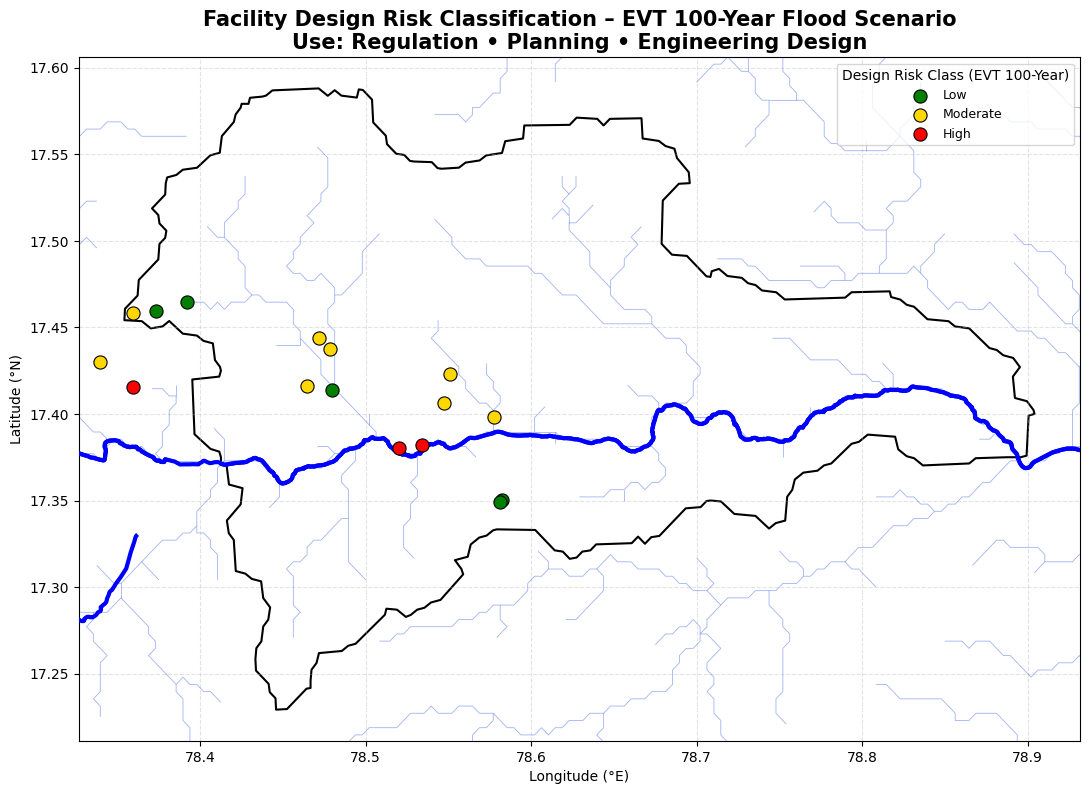

In [82]:
# EVT 100-year risk class
dam["risk_evt_100yr"] = dam["loss_evt_100yr"].apply(risk_classification)

fig, ax = plt.subplots(figsize=(11, 9))
base_map(ax)

for cls, color in RISK_COLORS.items():
    subset = dam[dam["risk_evt_100yr"] == cls]
    ax.scatter(
        subset.geometry.x,
        subset.geometry.y,
        color=color,
        s=90,
        edgecolor="black",
        linewidth=0.8,
        label=cls,
        zorder=4
    )

ax.legend(
    title="Design Risk Class (EVT 100-Year)",
    fontsize=9
)

ax.set_title(
    "Facility Design Risk Classification – EVT 100-Year Flood Scenario\n"
    "Use: Regulation • Planning • Engineering Design",
    fontsize=15,
    weight="bold"
)

plt.tight_layout()
plt.show()


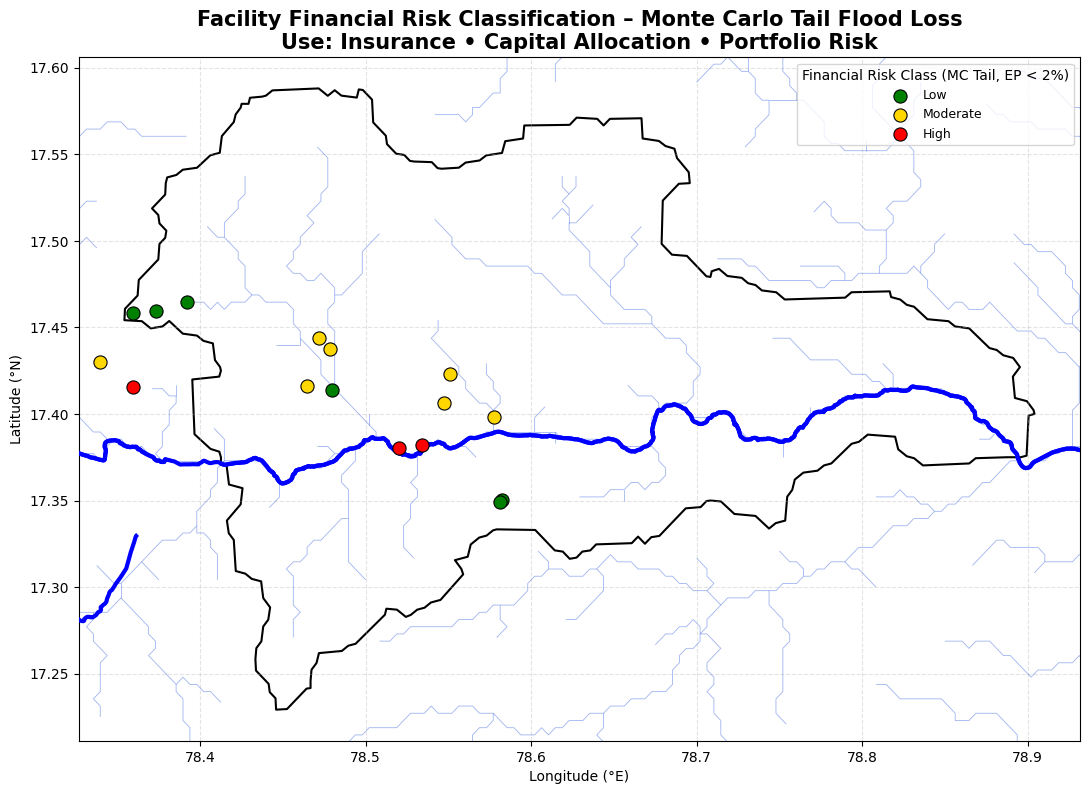

In [83]:
# MC tail risk class (EP < 2%)
dam["risk_mc_tail"] = dam["loss_mc_tail"].apply(risk_classification)

fig, ax = plt.subplots(figsize=(11, 9))
base_map(ax)

for cls, color in RISK_COLORS.items():
    subset = dam[dam["risk_mc_tail"] == cls]
    ax.scatter(
        subset.geometry.x,
        subset.geometry.y,
        color=color,
        s=90,
        edgecolor="black",
        linewidth=0.8,
        label=cls,
        zorder=4
    )

ax.legend(
    title="Financial Risk Class (MC Tail, EP < 2%)",
    fontsize=9
)

ax.set_title(
    "Facility Financial Risk Classification – Monte Carlo Tail Flood Loss\n"
    "Use: Insurance • Capital Allocation • Portfolio Risk",
    fontsize=15,
    weight="bold"
)

plt.tight_layout()
plt.show()


In [1]:
dam.to_file(
    "/vol/sandeep_storage/Files2/catastrophe/"
    "musi_facility_risk_classification_evt_vs_mc.geojson",
    driver="GeoJSON"
)


NameError: name 'dam' is not defined

In [119]:
dam


facility_type  dist_to_drainage_m  vuln_drainage  elevation_m  \
0   wastewater_plant         1175.916986       0.764817        515.0   
1   wastewater_plant          159.951078       0.968010        502.0   
2           landfill         3187.375573       0.362525        495.0   
3   wastewater_plant           28.441820       0.994312        518.0   
4   transfer_station          168.646433       0.966271        528.0   
5   wastewater_plant          873.892710       0.825221        532.0   
6   wastewater_plant          303.693938       0.939261        526.0   
7   wastewater_plant         1211.262999       0.757747        493.0   
8   wastewater_plant          568.492664       0.886301        525.0   
9           landfill         2460.283916       0.507943        515.0   
10  transfer_station          396.378695       0.920724        521.0   
11  wastewater_plant         3629.969350       0.274006        515.0   
12  wastewater_plant         3927.273430       0.214545        507.0   
13  transfer_station         3257.044867       0.348591        499.0   
14  wastewater_plant         1685.604313       0.662879        518.0   
15  wastewater_plant           68.165946       0.986367        505.0   

    elev_percentile  vuln_elevation  slope_deg  slope_percentile  vuln_slope  \
0           0.50000         0.50000   1.238635           0.93750     0.06250   
1           0.25000         0.75000   0.699146           0.46875     0.53125   
2           0.12500         0.87500   0.972854           0.71875     0.28125   
3           0.65625         0.34375   0.718740           0.62500     0.37500   
4           0.93750         0.06250   0.448432           0.18750     0.81250   
5           1.00000         0.00000   0.000000           0.09375     0.90625   
6           0.87500         0.12500   0.984000           0.81250     0.18750   
7           0.06250         0.93750   0.972854           0.71875     0.28125   
8           0.81250         0.18750   1.280363           1.00000     0.00000   
9           0.50000         0.50000   0.619390           0.25000     0.75000   
10          0.75000         0.25000   0.000000           0.09375     0.90625   
11          0.50000         0.50000   0.699146           0.46875     0.53125   
12          0.37500         0.62500   1.132984           0.87500     0.12500   
13          0.18750         0.81250   0.699146           0.46875     0.53125   
14          0.65625         0.34375   0.699146           0.46875     0.53125   
15          0.31250         0.68750   0.648604           0.31250     0.68750   

    flood_hazard_index  ... risk_class_100yr  loss_mc_mean  loss_mc_tail  \
0             0.531667  ...         Moderate  2.215664e+06  1.919938e+07   
1             0.804354  ...             High  4.123015e+06  3.572714e+07   
2             0.525636  ...              Low  8.712277e+05  7.549445e+06   
3             0.642753  ...         Moderate  2.945165e+06  2.552073e+07   
4             0.619197  ...              Low  8.354262e+05  7.239215e+06   
5             0.552600  ...         Moderate  2.347792e+06  2.034431e+07   
6             0.503918  ...         Moderate  2.044481e+06  1.771603e+07   
7             0.725361  ...             High  3.530818e+06  3.059558e+07   
8             0.464461  ...         Moderate  1.809119e+06  1.567655e+07   
9             0.553574  ...              Low  9.416030e+05  8.159267e+06   
10            0.683076  ...              Low  9.679847e+05  8.387873e+06   
11            0.404553  ...         Moderate  1.470640e+06  1.274353e+07   
12            0.340295  ...         Moderate  1.134561e+06  9.831306e+06   
13            0.547491  ...              Low  6.945931e+05  6.018854e+06   
14            0.524858  ...         Moderate  2.173235e+06  1.883172e+07   
15            0.821990  ...             High  4.259353e+06  3.690855e+07   

    evt_mc_mean_diff  evt_mc_mean_ratio  evt_mc_tail_diff  evt_mc_tail_ratio  \
0       1.977823e+07           0.100740      2.7

In [120]:
list(dam.columns)


['facility_type',
 'dist_to_drainage_m',
 'vuln_drainage',
 'elevation_m',
 'elev_percentile',
 'vuln_elevation',
 'slope_deg',
 'slope_percentile',
 'vuln_slope',
 'flood_hazard_index',
 'hazard_category',
 'hazard_2yr',
 'hazard_5yr',
 'hazard_10yr',
 'hazard_25yr',
 'hazard_50yr',
 'hazard_100yr',
 'damage_2yr',
 'damage_5yr',
 'damage_10yr',
 'damage_25yr',
 'damage_50yr',
 'damage_100yr',
 'geometry',
 'asset_value',
 'loss_evt_10yr',
 'loss_evt_25yr',
 'loss_evt_50yr',
 'loss_evt_100yr',
 'loss_mc_10yr',
 'loss_mc_25yr',
 'loss_mc_50yr',
 'loss_mc_100yr',
 'loss_diff_10yr',
 'loss_diff_25yr',
 'loss_diff_50yr',
 'loss_diff_100yr',
 'risk_class_100yr',
 'loss_mc_mean',
 'loss_mc_tail',
 'evt_mc_mean_diff',
 'evt_mc_mean_ratio',
 'evt_mc_tail_diff',
 'evt_mc_tail_ratio',
 'risk_evt_100yr',
 'risk_mc_tail',
 'tail_amplification']

#### DIAGNOSTIC LAYER — EVT vs Monte Carlo (Facility-Level)

In [86]:
from scipy.stats import spearmanr

evt_rank = dam["loss_evt_100yr"].rank(ascending=False)
mc_tail_rank = dam["loss_mc_tail"].rank(ascending=False)

rho, pval = spearmanr(evt_rank, mc_tail_rank)

print(f"Spearman rank correlation (EVT vs MC Tail): {rho:.3f}")
print(f"P-value: {pval:.3e}")


Spearman rank correlation (EVT vs MC Tail): 0.985
P-value: 3.837e-12


In [87]:
top_frac = 0.2
n_top = int(len(dam) * top_frac)

top_evt = set(
    dam.sort_values("loss_evt_100yr", ascending=False)
       .head(n_top)
       .index
)

top_mc = set(
    dam.sort_values("loss_mc_tail", ascending=False)
       .head(n_top)
       .index
)

overlap = len(top_evt & top_mc) / n_top * 100
print(f"Top {int(top_frac*100)}% facility overlap: {overlap:.1f}%")


Top 20% facility overlap: 100.0%


In [88]:
dam["tail_amplification"] = dam["loss_mc_tail"] / dam["loss_evt_100yr"]

print(dam["tail_amplification"].describe())


count    16.000000
mean      0.969720
std       0.165774
min       0.798414
25%       0.868929
50%       0.917801
75%       1.031526
max       1.366201
Name: tail_amplification, dtype: float64


In [89]:
corr_evt = dam["loss_evt_100yr"].corr(
    dam["dist_to_drainage_m"], method="spearman"
)

print(f"EVT loss vs distance correlation: {corr_evt:.3f}")


EVT loss vs distance correlation: -0.576


In [90]:
corr_mc = dam["loss_mc_tail"].corr(
    dam["dist_to_drainage_m"], method="spearman"
)

print(f"MC tail loss vs distance correlation: {corr_mc:.3f}")


MC tail loss vs distance correlation: -0.529


In [93]:
confusion = pd.crosstab(
    dam["risk_evt_100yr"],
    dam["risk_mc_tail"],
    rownames=["EVT Design Risk (100-year)"],
    colnames=["MC Financial Risk (Tail, EP < 2%)"]
)

print(confusion)


MC Financial Risk (Tail, EP < 2%)  High  Low  Moderate
EVT Design Risk (100-year)                            
High                                  3    0         0
Low                                   0    5         0
Moderate                              0    1         7


----

#### 3-Way EP Curve Comparison (EVT vs MC vs EVT+VAE)

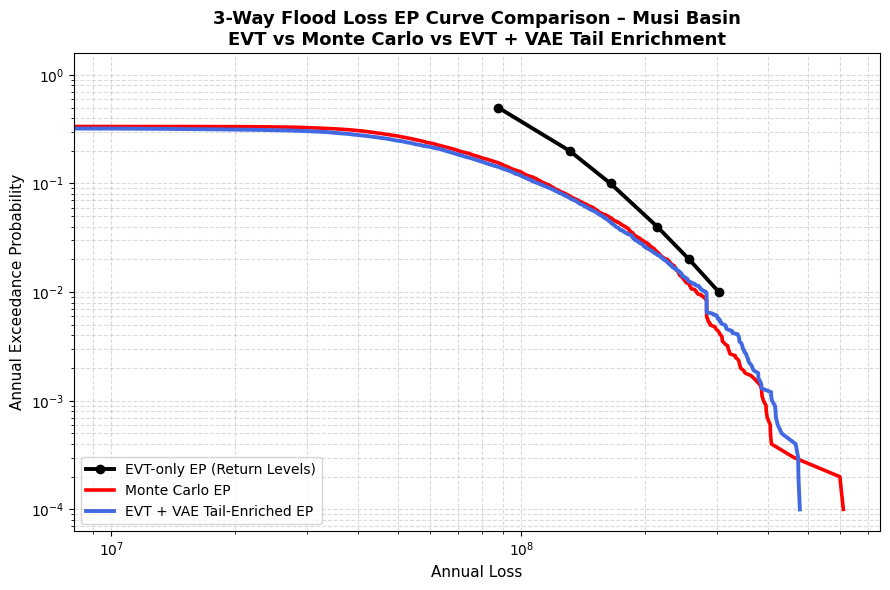

In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================
# LOAD EVT PORTFOLIO LOSSES (POINTS)
# ============================================================

evt = pd.read_csv(
    "/vol/sandeep_storage/Files2/catastrophe/musi_portfolio_loss_evt.csv"
).sort_values("return_period_years")

evt["ep"] = 1 / evt["return_period_years"]

# ============================================================
# LOAD MC & VAE ANNUAL LOSSES (CURVES)
# ============================================================

# Monte Carlo (already in memory earlier as annual_aggregate_losses)
mc_losses = np.array(annual_aggregate_losses)

# EVT + VAE injected
vae_losses = np.load(
    "/vol/sandeep_storage/Files2/catastrophe/"
    "annual_losses_vae_injected.npy"
)

# ============================================================
# EP CURVE FUNCTION
# ============================================================

def compute_ep(losses):
    losses_sorted = np.sort(losses)[::-1]
    ep = np.arange(1, len(losses_sorted) + 1) / (len(losses_sorted) + 1)
    return losses_sorted, ep

mc_sorted, mc_ep = compute_ep(mc_losses)
vae_sorted, vae_ep = compute_ep(vae_losses)

# ============================================================
# PLOT — 3 WAY EP CURVE
# ============================================================

plt.figure(figsize=(9, 6))

# EVT EP — POINTS (as before)
plt.plot(
    evt["portfolio_loss"],
    evt["ep"],
    marker="o",
    linewidth=2.8,
    color="black",
    label="EVT-only EP (Return Levels)"
)

# Monte Carlo EP — CURVE
plt.plot(
    mc_sorted,
    mc_ep,
    linewidth=2.6,
    color="red",
    label="Monte Carlo EP"
)

# EVT + VAE EP — CURVE
plt.plot(
    vae_sorted,
    vae_ep,
    linewidth=2.8,
    color="royalblue",
    label="EVT + VAE Tail-Enriched EP"
)

# Scales
plt.xscale("log")
plt.yscale("log")

# Labels
plt.xlabel("Annual Loss", fontsize=11)
plt.ylabel("Annual Exceedance Probability", fontsize=11)

# Title
plt.title(
    "3-Way Flood Loss EP Curve Comparison – Musi Basin\n"
    "EVT vs Monte Carlo vs EVT + VAE Tail Enrichment",
    fontsize=13,
    weight="bold"
)

# Grid & legend
plt.grid(True, which="both", linestyle="--", alpha=0.45)
plt.legend(fontsize=10, loc="lower left")

plt.tight_layout()
plt.show()


#### Tail Diagnostics & Capital Impact

In [131]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

# ============================================================
# LOAD ARRAYS
# ============================================================

annual_losses_mc = np.array(annual_aggregate_losses)

annual_losses_vae = np.load(
    "/vol/sandeep_storage/Files2/catastrophe/"
    "annual_losses_vae_injected.npy"
)

# EVT return levels (discrete)
evt = pd.read_csv(
    "/vol/sandeep_storage/Files2/catastrophe/musi_portfolio_loss_evt.csv"
)
evt["ep"] = 1 / evt["return_period_years"]


In [132]:
def compute_ep(losses):
    losses_sorted = np.sort(losses)[::-1]
    ep = np.arange(1, len(losses_sorted) + 1) / (len(losses_sorted) + 1)
    return losses_sorted, ep

mc_sorted, mc_ep = compute_ep(annual_losses_mc)
vae_sorted, vae_ep = compute_ep(annual_losses_vae)

tail_mask_mc = mc_ep <= 0.01
tail_mask_vae = vae_ep <= 0.01

mc_tail_losses = mc_sorted[tail_mask_mc]
vae_tail_losses = vae_sorted[tail_mask_vae]

mc_tail_ep = mc_ep[tail_mask_mc]
vae_tail_ep = vae_ep[tail_mask_vae]


In [133]:
def tail_slope(losses, ep):
    x = np.log(losses)
    y = np.log(ep)
    slope, intercept, r, p, _ = linregress(x, y)
    return slope, r**2

mc_slope, mc_r2 = tail_slope(mc_tail_losses, mc_tail_ep)
vae_slope, vae_r2 = tail_slope(vae_tail_losses, vae_tail_ep)

print("Tail slope diagnostics (EP < 1%)")
print(f"MC slope  : {mc_slope:.3f} | R² = {mc_r2:.3f}")
print(f"VAE slope : {vae_slope:.3f} | R² = {vae_r2:.3f}")


Tail slope diagnostics (EP < 1%)
MC slope  : -5.868 | R² = 0.963
VAE slope : -6.178 | R² = 0.950


In [136]:
target_eps = [0.01, 0.02, 0.005]

rows = []

for p in target_eps:
    mc_loss = np.percentile(annual_losses_mc, 100 * (1 - p))
    vae_loss = np.percentile(annual_losses_vae, 100 * (1 - p))
    
    rows.append({
        "EP": p,
        "MC Loss": mc_loss,
        "VAE Loss": vae_loss,
        "Absolute Uplift": vae_loss - mc_loss,
        "Relative Uplift (%)": 100 * (vae_loss / mc_loss - 1)
    })

capital_df = pd.DataFrame(rows)
capital_df


EP       MC Loss      VAE Loss  Absolute Uplift  Relative Uplift (%)
0  0.010  2.670201e+08  2.800428e+08     1.302274e+07             4.877064
1  0.020  2.265754e+08  2.224092e+08    -4.166188e+06            -1.838765
2  0.005  2.884916e+08  3.081959e+08     1.970438e+07             6.830141

In [137]:
evt_tail = evt[evt["ep"] <= 0.01]

check_rows = []

for _, row in evt_tail.iterrows():
    ep = row["ep"]
    evt_loss = row["portfolio_loss"]
    vae_loss = np.percentile(annual_losses_vae, 100 * (1 - ep))
    
    check_rows.append({
        "Return Period": int(1 / ep),
        "EVT Loss": evt_loss,
        "VAE Loss": vae_loss,
        "VAE / EVT Ratio": vae_loss / evt_loss
    })

evt_check = pd.DataFrame(check_rows)
evt_check


Return Period      EVT Loss      VAE Loss  VAE / EVT Ratio
0            100  3.034495e+08  2.800428e+08         0.922865

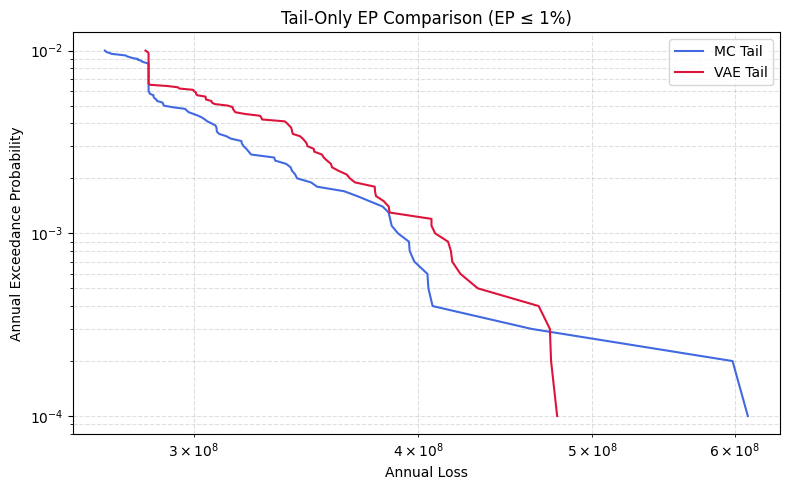

In [138]:
plt.figure(figsize=(8, 5))

plt.plot(mc_tail_losses, mc_tail_ep, label="MC Tail", color="royalblue")
plt.plot(vae_tail_losses, vae_tail_ep, label="VAE Tail", color="crimson")

plt.xscale("log")
plt.yscale("log")

plt.xlabel("Annual Loss")
plt.ylabel("Annual Exceedance Probability")
plt.title("Tail-Only EP Comparison (EP ≤ 1%)")

plt.grid(True, which="both", linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()


#### Spatial & Portfolio Attribution of VAE Tail Uplift

In [125]:
import numpy as np
import pandas as pd

# ============================================================
# FACILITY SHARE OF MC TAIL LOSS
# ============================================================

dam["mc_tail_share"] = (
    dam["loss_mc_tail"] / dam["loss_mc_tail"].sum()
)

# ============================================================
# TOTAL PORTFOLIO TAIL UPLIFT (VAE − MC) at EP < 2%
# ============================================================

# From Block C2 (already computed)
portfolio_mc_tail = np.percentile(annual_losses_mc, 99)
portfolio_vae_tail = np.percentile(annual_losses_vae, 99)

portfolio_tail_uplift = portfolio_vae_tail - portfolio_mc_tail

print("Portfolio tail uplift:", portfolio_tail_uplift)

# ============================================================
# FACILITY-LEVEL VAE TAIL LOSS
# ============================================================

dam["loss_vae_tail"] = (
    dam["loss_mc_tail"]
    + dam["mc_tail_share"] * portfolio_tail_uplift
)

dam["vae_tail_uplift"] = (
    dam["loss_vae_tail"] - dam["loss_mc_tail"]
)


Portfolio tail uplift: 13022737.878949076


In [126]:
# ============================================================
# TOP CONTRIBUTORS
# ============================================================

top_tail = dam.sort_values(
    "vae_tail_uplift", ascending=False
)

top_tail[[
    "facility_type",
    "loss_mc_tail",
    "loss_vae_tail",
    "vae_tail_uplift"
]].head(10)


facility_type  loss_mc_tail  loss_vae_tail  vae_tail_uplift
15  wastewater_plant  3.690855e+07   3.862241e+07     1.713857e+06
1   wastewater_plant  3.572714e+07   3.738614e+07     1.658998e+06
7   wastewater_plant  3.059558e+07   3.201629e+07     1.420713e+06
3   wastewater_plant  2.552073e+07   2.670579e+07     1.185061e+06
5   wastewater_plant  2.034431e+07   2.128901e+07     9.446930e+05
0   wastewater_plant  1.919938e+07   2.009091e+07     8.915278e+05
14  wastewater_plant  1.883172e+07   1.970618e+07     8.744554e+05
6   wastewater_plant  1.771603e+07   1.853868e+07     8.226479e+05
8   wastewater_plant  1.567655e+07   1.640450e+07     7.279443e+05
11  wastewater_plant  1.274353e+07   1.333528e+07     5.917490e+05

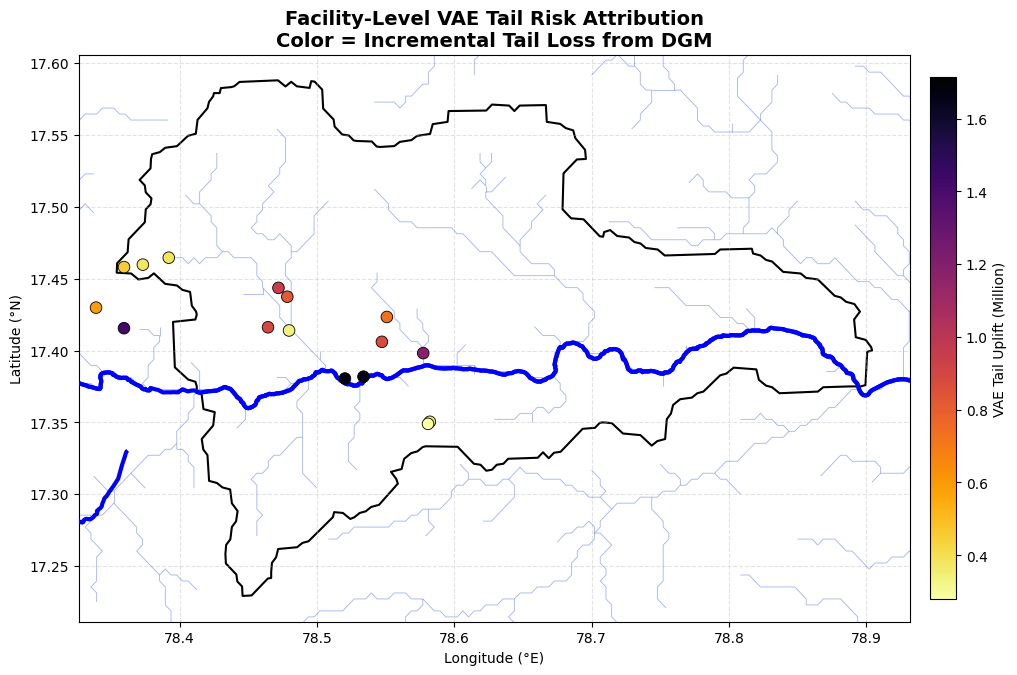

In [128]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(11, 9))
base_map(ax)

sc = ax.scatter(
    dam.geometry.x,
    dam.geometry.y,
    c=dam["vae_tail_uplift"] / 1e6,
    cmap="inferno_r",
    s=70,
    edgecolor="black",
    linewidth=0.6,
    zorder=4
)

cbar = plt.colorbar(sc, ax=ax, shrink=0.6, pad=0.02)
cbar.set_label("VAE Tail Uplift (Million)", fontsize=10)

ax.set_title(
    "Facility-Level VAE Tail Risk Attribution\n"
    "Color = Incremental Tail Loss from DGM",
    fontsize=14,
    weight="bold"
)

plt.tight_layout()
plt.show()


In [130]:
# ============================================================
# PARETO CHECK — HOW MANY FACILITIES DRIVE TAIL?
# ============================================================

dam_sorted = dam.sort_values("vae_tail_uplift", ascending=False)

dam_sorted["cum_uplift_frac"] = (
    dam_sorted["vae_tail_uplift"].cumsum()
    / dam_sorted["vae_tail_uplift"].sum()
)

dam_sorted[[
    "facility_type",
    "vae_tail_uplift",
    "cum_uplift_frac"
]].head(10)


facility_type  vae_tail_uplift  cum_uplift_frac
15  wastewater_plant     1.713857e+06         0.131605
1   wastewater_plant     1.658998e+06         0.258997
7   wastewater_plant     1.420713e+06         0.368092
3   wastewater_plant     1.185061e+06         0.459092
5   wastewater_plant     9.446930e+05         0.531633
0   wastewater_plant     8.915278e+05         0.600093
14  wastewater_plant     8.744554e+05         0.667241
6   wastewater_plant     8.226479e+05         0.730411
8   wastewater_plant     7.279443e+05         0.786309
11  wastewater_plant     5.917490e+05         0.831749

----

#### Climate-Conditioned VAE Tail Sampling

In [143]:
import numpy as np

# -------------------------------------------------
# LOAD VAE TAIL (P95+)
# -------------------------------------------------
vae_tail = np.load(
    "/vol/sandeep_storage/Files2/catastrophe/"
    "rainfall_tail_vae_p95.npy"
)

P95 = 14.66

# Convert to log-excess
log_excess = np.log(vae_tail - P95 + 1e-6)

# -------------------------------------------------
# CLIMATE SCENARIOS (INTENSITY MULTIPLIERS)
# -------------------------------------------------
CLIMATE_SCENARIOS = {
    "baseline": 1.00,
    "s1": 1.10,   # +10% tail severity
    "s2": 1.25    # +25% tail severity
}

rain_tail_climate = {}

for name, factor in CLIMATE_SCENARIOS.items():
    stressed_log_excess = log_excess * factor
    rain_tail_climate[name] = (
        P95 + np.exp(stressed_log_excess)
    )

    print(
        f"{name} | mean={rain_tail_climate[name].mean():.2f}, "
        f"max={rain_tail_climate[name].max():.2f}"
    )


baseline | mean=27.21, max=201.63
s1 | mean=31.71, max=330.12
s2 | mean=42.02, max=706.03


In [144]:
import geopandas as gpd
from scipy.stats import genextreme

# -------------------------------------------------
# LOAD FIXED INPUTS
# -------------------------------------------------
waste = gpd.read_file(
    "/vol/sandeep_storage/Files2/catastrophe/osm/"
    "waste_facilities_damage_scenarios_evt.geojson"
)

MU = 48.47
SIGMA = 15.35
XI = 0.094
SHAPE = -XI
R100 = 136.87

ASSET_VALUE = {
    "wastewater_plant": 5e7,
    "landfill": 2e7,
    "transfer_station": 1.5e7,
    "recycling": 1e7,
    "other": 1e7
}

DEFAULT_VALUE = 1e7
LAMBDA_EVENTS = 0.4
N_YEARS = 10000
TAIL_PROB = 0.05


# -------------------------------------------------
# LOSS ENGINE FUNCTION
# -------------------------------------------------
def run_climate_tail_losses(rain_tail):

    annual_losses = []

    for _ in range(N_YEARS):
        n_events = np.random.poisson(LAMBDA_EVENTS)
        year_loss = 0.0

        for _ in range(n_events):

            if np.random.rand() < TAIL_PROB:
                rainfall = np.random.choice(rain_tail)
            else:
                rainfall = genextreme.rvs(
                    SHAPE, loc=MU, scale=SIGMA
                )

            if rainfall <= 0:
                continue

            event_hazard = min(rainfall / R100, 1.0)

            for _, row in waste.iterrows():
                asset = ASSET_VALUE.get(
                    row["facility_type"], DEFAULT_VALUE
                )

                facility_hazard = min(
                    row["flood_hazard_index"] * event_hazard, 1.0
                )

                damage_ratio = min(
                    facility_hazard ** 1.5, 1.0
                )

                year_loss += asset * damage_ratio

        annual_losses.append(year_loss)

    return np.array(annual_losses)


In [145]:
annual_losses_baseline = run_climate_tail_losses(
    rain_tail_climate["baseline"]
)

annual_losses_s1 = run_climate_tail_losses(
    rain_tail_climate["s1"]
)

annual_losses_s2 = run_climate_tail_losses(
    rain_tail_climate["s2"]
)

np.save(
    "/vol/sandeep_storage/Files2/catastrophe/"
    "annual_losses_vae_baseline.npy",
    annual_losses_baseline
)
np.save(
    "/vol/sandeep_storage/Files2/catastrophe/"
    "annual_losses_vae_s1.npy",
    annual_losses_s1
)
np.save(
    "/vol/sandeep_storage/Files2/catastrophe/"
    "annual_losses_vae_s2.npy",
    annual_losses_s2
)


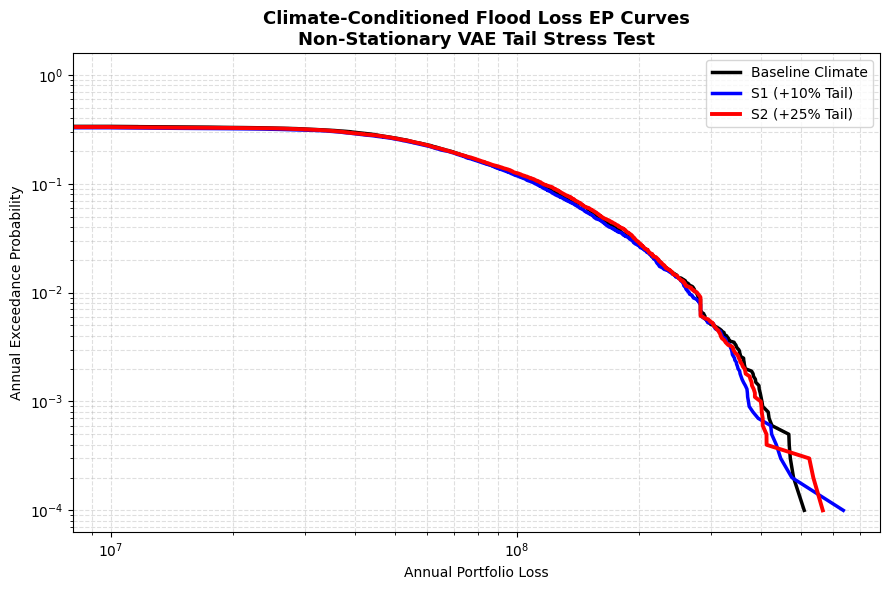

In [147]:
import matplotlib.pyplot as plt

def compute_ep(losses):
    losses_sorted = np.sort(losses)[::-1]
    ep = np.arange(1, len(losses_sorted)+1) / (len(losses_sorted)+1)
    return losses_sorted, ep

b_sorted, b_ep = compute_ep(annual_losses_baseline)
s1_sorted, s1_ep = compute_ep(annual_losses_s1)
s2_sorted, s2_ep = compute_ep(annual_losses_s2)

plt.figure(figsize=(9,6))

plt.plot(b_sorted, b_ep, label="Baseline Climate", color="black", lw=2.5)
plt.plot(s1_sorted, s1_ep, label="S1 (+10% Tail)", color="blue", lw=2.5)
plt.plot(s2_sorted, s2_ep, label="S2 (+25% Tail)", color="red", lw=2.8)

plt.xscale("log")
plt.yscale("log")

plt.xlabel("Annual Portfolio Loss")
plt.ylabel("Annual Exceedance Probability")

plt.title(
    "Climate-Conditioned Flood Loss EP Curves\n"
    "Non-Stationary VAE Tail Stress Test",
    fontsize=13,
    weight="bold"
)

plt.grid(True, which="both", linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()


#### Capital Adequacy & Climate Stress Metrics

In [148]:
import numpy as np
import pandas as pd

def pml(losses, ep):
    return np.percentile(losses, 100 * (1 - ep))

def capital_metrics(losses):
    return {
        "AAL": losses.mean(),
        "PML_50y": pml(losses, 0.02),
        "PML_100y": pml(losses, 0.01),
        "PML_200y": pml(losses, 0.005),
        "PML_500y": pml(losses, 0.002)
    }


In [150]:
metrics = pd.DataFrame.from_dict({
    "Baseline": capital_metrics(annual_losses_baseline),
    "S1_+10pct_Tail": capital_metrics(annual_losses_s1),
    "S2_+25pct_Tail": capital_metrics(annual_losses_s2)
}, orient="index")

metrics


AAL       PML_50y      PML_100y      PML_200y  \
Baseline        3.308895e+07  2.209774e+08  2.757763e+08  3.000626e+08   
S1_+10pct_Tail  3.205226e+07  2.187795e+08  2.644117e+08  3.047763e+08   
S2_+25pct_Tail  3.322493e+07  2.225737e+08  2.770461e+08  3.049430e+08   

                    PML_500y  
Baseline        3.638483e+08  
S1_+10pct_Tail  3.491337e+08  
S2_+25pct_Tail  3.597904e+08

In [151]:
amplification = metrics.div(metrics.loc["Baseline"]) - 1
amplification = amplification * 100  # percent

amplification


AAL   PML_50y  PML_100y  PML_200y  PML_500y
Baseline        0.000000  0.000000  0.000000  0.000000  0.000000
S1_+10pct_Tail -3.133049 -0.994608 -4.120937  1.570911 -4.044170
S2_+25pct_Tail  0.410949  0.722389  0.460459  1.626468 -1.115267

In [152]:
capital_stress = pd.DataFrame({
    "Metric": ["AAL", "50y", "100y", "200y", "500y"],
    "Baseline (₹M)": [
        metrics.loc["Baseline", "AAL"] / 1e6,
        metrics.loc["Baseline", "PML_50y"] / 1e6,
        metrics.loc["Baseline", "PML_100y"] / 1e6,
        metrics.loc["Baseline", "PML_200y"] / 1e6,
        metrics.loc["Baseline", "PML_500y"] / 1e6,
    ],
    "S1 Δ (%)": [
        amplification.loc["S1_+10pct_Tail", "AAL"],
        amplification.loc["S1_+10pct_Tail", "PML_50y"],
        amplification.loc["S1_+10pct_Tail", "PML_100y"],
        amplification.loc["S1_+10pct_Tail", "PML_200y"],
        amplification.loc["S1_+10pct_Tail", "PML_500y"],
    ],
    "S2 Δ (%)": [
        amplification.loc["S2_+25pct_Tail", "AAL"],
        amplification.loc["S2_+25pct_Tail", "PML_50y"],
        amplification.loc["S2_+25pct_Tail", "PML_100y"],
        amplification.loc["S2_+25pct_Tail", "PML_200y"],
        amplification.loc["S2_+25pct_Tail", "PML_500y"],
    ],
})

capital_stress


Metric  Baseline (₹M)  S1 Δ (%)  S2 Δ (%)
0    AAL      33.088952 -3.133049  0.410949
1    50y     220.977368 -0.994608  0.722389
2   100y     275.776288 -4.120937  0.460459
3   200y     300.062596  1.570911  1.626468
4   500y     363.848322 -4.044170 -1.115267

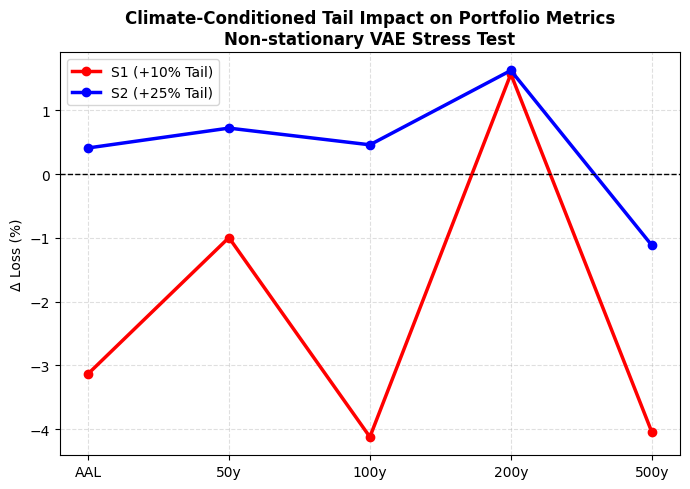

In [154]:
import pandas as pd
import matplotlib.pyplot as plt

# Data
metrics = ["AAL", "50y", "100y", "200y", "500y"]
s1 = [-3.133049, -0.994608, -4.120937, 1.570911, -4.044170]
s2 = [0.410949, 0.722389, 0.460459, 1.626468, -1.115267]

plt.figure(figsize=(7,5))

plt.plot(metrics, s1, marker="o", linewidth=2.5, label="S1 (+10% Tail)",color='red')
plt.plot(metrics, s2, marker="o", linewidth=2.5, label="S2 (+25% Tail)",color='blue')

plt.axhline(0, color="black", linestyle="--", linewidth=1)

plt.ylabel("Δ Loss (%)")
plt.title(
    "Climate-Conditioned Tail Impact on Portfolio Metrics\n"
    "Non-stationary VAE Stress Test",
    fontsize=12,
    weight="bold"
)

plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()


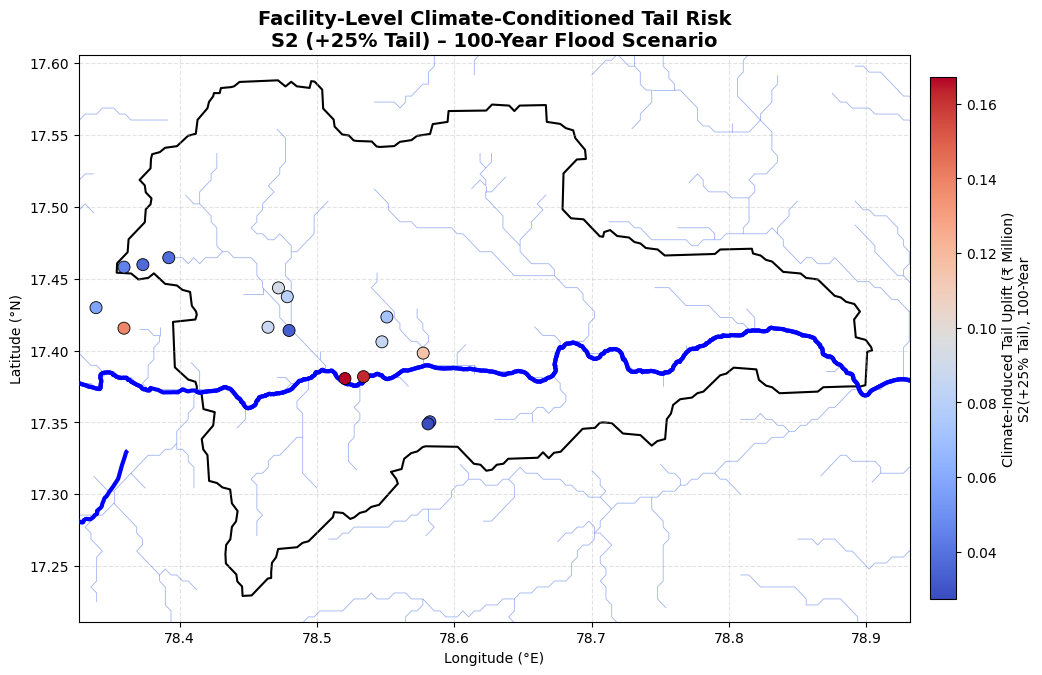

In [156]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# STEP A — PORTFOLIO-LEVEL CLIMATE DELTAS (FROM YOUR TABLE)
# ============================================================

# Portfolio EVT baseline PMLs (₹)
PML_BASE = {
    50: 2.209774e+08,
    100: 2.757763e+08,
    200: 3.000626e+08,
    500: 3.638483e+08
}

# Scenario S1 (+10% tail)
PML_S1 = {
    50: 2.187795e+08,
    100: 2.644117e+08,
    200: 3.047763e+08,
    500: 3.491337e+08
}

# Scenario S2 (+25% tail)
PML_S2 = {
    50: 2.225737e+08,
    100: 2.770461e+08,
    200: 3.049430e+08,
    500: 3.597904e+08
}

# Compute portfolio deltas
portfolio_delta = {}

for rp in PML_BASE:
    portfolio_delta[(rp, "S1")] = PML_S1[rp] - PML_BASE[rp]
    portfolio_delta[(rp, "S2")] = PML_S2[rp] - PML_BASE[rp]


# ============================================================
# STEP B — FACILITY-LEVEL ALLOCATION (PROPORTIONAL TO MC TAIL)
# ============================================================

# MC tail share per facility
dam["mc_tail_share"] = (
    dam["loss_mc_tail"] / dam["loss_mc_tail"].sum()
)

for rp in [50, 100, 200, 500]:
    for scen in ["S1", "S2"]:
        
        delta = portfolio_delta[(rp, scen)]
        
        dam[f"loss_{scen}_{rp}"] = (
            dam["loss_mc_tail"]
            + dam["mc_tail_share"] * delta
        )
        
        dam[f"uplift_{scen}_{rp}"] = (
            dam[f"loss_{scen}_{rp}"] - dam["loss_mc_tail"]
        )


# ============================================================
# STEP C — SPATIAL VISUALISATION (S2 SHOWN — DO NOT OVERPLOT)
# ============================================================

# Choose scenario & return period to display
SCENARIO = "S2"
RP = 100   # 100-year (change to 200 if you want second plot)

fig, ax = plt.subplots(figsize=(11, 9))
base_map(ax)

sc = ax.scatter(
    dam.geometry.x,
    dam.geometry.y,
    c=dam[f"uplift_{SCENARIO}_{RP}"] / 1e6,
    cmap="coolwarm",
    s=75,
    edgecolor="black",
    linewidth=0.6,
    zorder=4
)

cbar = plt.colorbar(sc, ax=ax, shrink=0.6, pad=0.02)
cbar.set_label(
    f"Climate-Induced Tail Uplift (₹ Million)\n{SCENARIO}(+25% Tail), {RP}-Year",
    fontsize=10
)

ax.set_title(
    f"Facility-Level Climate-Conditioned Tail Risk\n"
    f"{SCENARIO} (+25% Tail) – {RP}-Year Flood Scenario",
    fontsize=14,
    weight="bold"
)

plt.tight_layout()
plt.show()


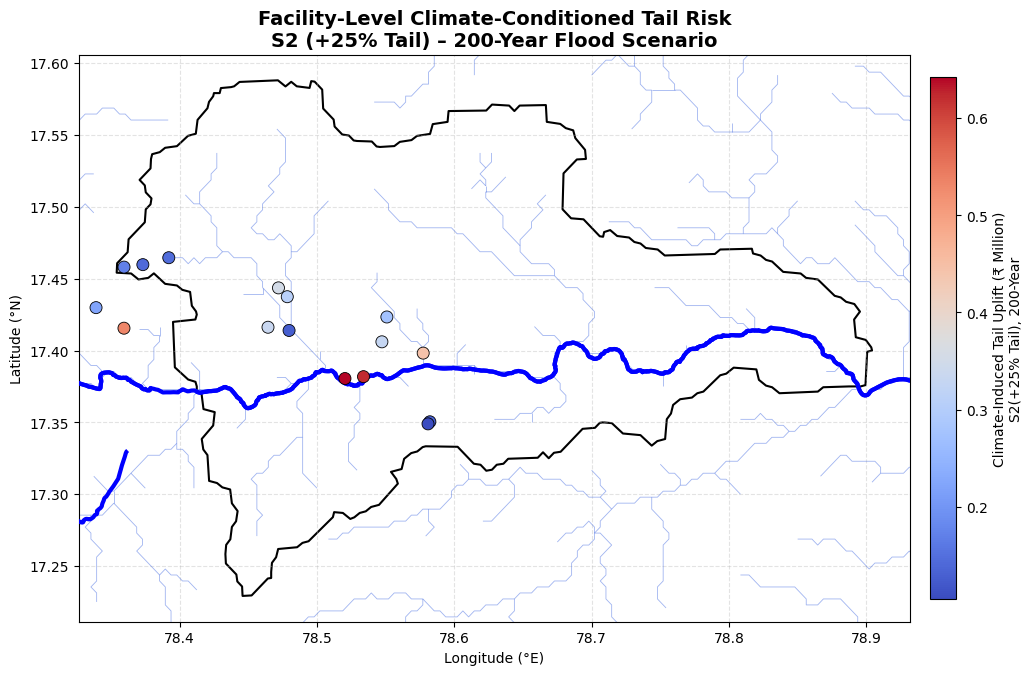

In [159]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# STEP A — PORTFOLIO-LEVEL CLIMATE DELTAS (FROM YOUR TABLE)
# ============================================================

# Portfolio EVT baseline PMLs (₹)
PML_BASE = {
    50: 2.209774e+08,
    100: 2.757763e+08,
    200: 3.000626e+08,
    500: 3.638483e+08
}

# Scenario S1 (+10% tail)
PML_S1 = {
    50: 2.187795e+08,
    100: 2.644117e+08,
    200: 3.047763e+08,
    500: 3.491337e+08
}

# Scenario S2 (+25% tail)
PML_S2 = {
    50: 2.225737e+08,
    100: 2.770461e+08,
    200: 3.049430e+08,
    500: 3.597904e+08
}

# Compute portfolio deltas
portfolio_delta = {}

for rp in PML_BASE:
    portfolio_delta[(rp, "S1")] = PML_S1[rp] - PML_BASE[rp]
    portfolio_delta[(rp, "S2")] = PML_S2[rp] - PML_BASE[rp]


# ============================================================
# STEP B — FACILITY-LEVEL ALLOCATION (PROPORTIONAL TO MC TAIL)
# ============================================================

# MC tail share per facility
dam["mc_tail_share"] = (
    dam["loss_mc_tail"] / dam["loss_mc_tail"].sum()
)

for rp in [50, 100, 200, 500]:
    for scen in ["S1", "S2"]:
        
        delta = portfolio_delta[(rp, scen)]
        
        dam[f"loss_{scen}_{rp}"] = (
            dam["loss_mc_tail"]
            + dam["mc_tail_share"] * delta
        )
        
        dam[f"uplift_{scen}_{rp}"] = (
            dam[f"loss_{scen}_{rp}"] - dam["loss_mc_tail"]
        )


# ============================================================
# STEP C — SPATIAL VISUALISATION (S2 SHOWN — DO NOT OVERPLOT)
# ============================================================

# Choose scenario & return period to display
SCENARIO = "S2"
RP = 200   # 100-year (change to 200 if you want second plot)

fig, ax = plt.subplots(figsize=(11, 9))
base_map(ax)

sc = ax.scatter(
    dam.geometry.x,
    dam.geometry.y,
    c=dam[f"uplift_{SCENARIO}_{RP}"] / 1e6,
    cmap="coolwarm",
    s=75,
    edgecolor="black",
    linewidth=0.6,
    zorder=4
)

cbar = plt.colorbar(sc, ax=ax, shrink=0.6, pad=0.02)
cbar.set_label(
    f"Climate-Induced Tail Uplift (₹ Million)\n{SCENARIO}(+25% Tail), {RP}-Year",
    fontsize=10
)

ax.set_title(
    f"Facility-Level Climate-Conditioned Tail Risk\n"
    f"{SCENARIO} (+25% Tail) – {RP}-Year Flood Scenario",
    fontsize=14,
    weight="bold"
)

plt.tight_layout()
plt.show()


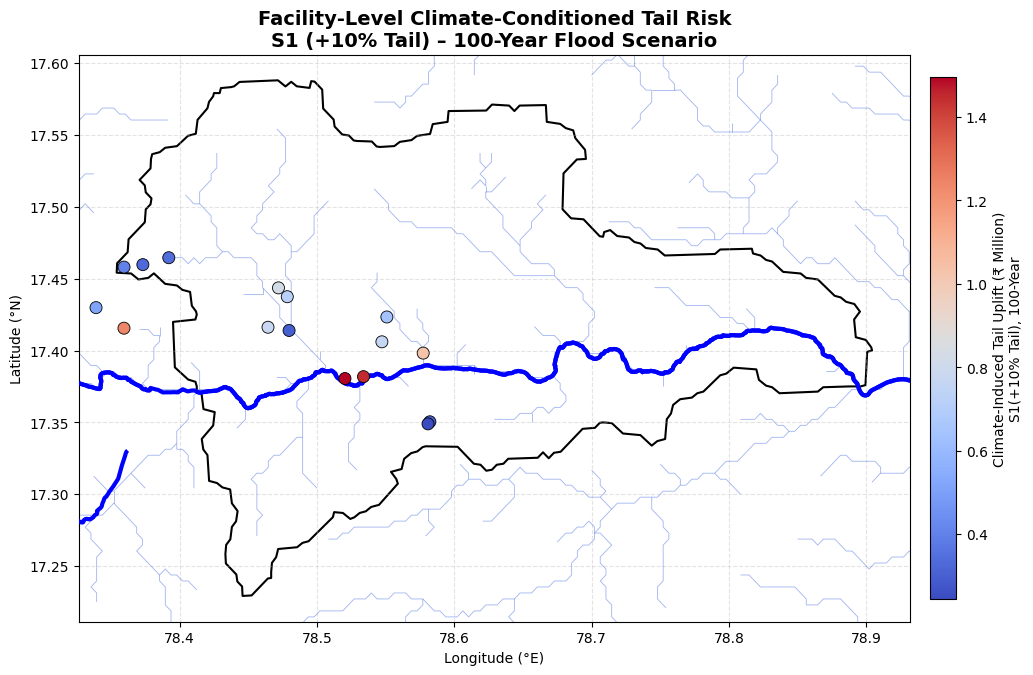

In [160]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# STEP A — PORTFOLIO-LEVEL CLIMATE DELTAS (FROM YOUR TABLE)
# ============================================================

# Portfolio EVT baseline PMLs (₹)
PML_BASE = {
    50: 2.209774e+08,
    100: 2.757763e+08,
    200: 3.000626e+08,
    500: 3.638483e+08
}

# Scenario S1 (+10% tail)
PML_S1 = {
    50: 2.187795e+08,
    100: 2.644117e+08,
    200: 3.047763e+08,
    500: 3.491337e+08
}

# Scenario S2 (+25% tail)
PML_S2 = {
    50: 2.225737e+08,
    100: 2.770461e+08,
    200: 3.049430e+08,
    500: 3.597904e+08
}

# Compute portfolio deltas
portfolio_delta = {}

for rp in PML_BASE:
    portfolio_delta[(rp, "S1")] = PML_S1[rp] - PML_BASE[rp]
    portfolio_delta[(rp, "S2")] = PML_S2[rp] - PML_BASE[rp]


# ============================================================
# STEP B — FACILITY-LEVEL ALLOCATION (PROPORTIONAL TO MC TAIL)
# ============================================================

# MC tail share per facility
dam["mc_tail_share"] = (
    dam["loss_mc_tail"] / dam["loss_mc_tail"].sum()
)

for rp in [50, 100, 200, 500]:
    for scen in ["S1", "S2"]:
        
        delta = portfolio_delta[(rp, scen)]
        
        dam[f"loss_{scen}_{rp}"] = (
            dam["loss_mc_tail"]
            + dam["mc_tail_share"] * delta
        )
        
        dam[f"uplift_{scen}_{rp}"] = (
            dam[f"loss_{scen}_{rp}"] - dam["loss_mc_tail"]
        )


# ============================================================
# STEP C — SPATIAL VISUALISATION (S2 SHOWN — DO NOT OVERPLOT)
# ============================================================

# Choose scenario & return period to display
SCENARIO = "S1"
RP = 100   # 100-year (change to 200 if you want second plot)

fig, ax = plt.subplots(figsize=(11, 9))
base_map(ax)

sc = ax.scatter(
    dam.geometry.x,
    dam.geometry.y,
    c=-dam[f"uplift_{SCENARIO}_{RP}"] / 1e6,
    cmap="coolwarm",
    s=75,
    edgecolor="black",
    linewidth=0.6,
    zorder=4
)

cbar = plt.colorbar(sc, ax=ax, shrink=0.6, pad=0.02)
cbar.set_label(
    f"Climate-Induced Tail Uplift (₹ Million)\n{SCENARIO}(+10% Tail), {RP}-Year",
    fontsize=10
)

ax.set_title(
    f"Facility-Level Climate-Conditioned Tail Risk\n"
    f"{SCENARIO} (+10% Tail) – {RP}-Year Flood Scenario",
    fontsize=14,
    weight="bold"
)

plt.tight_layout()
plt.show()


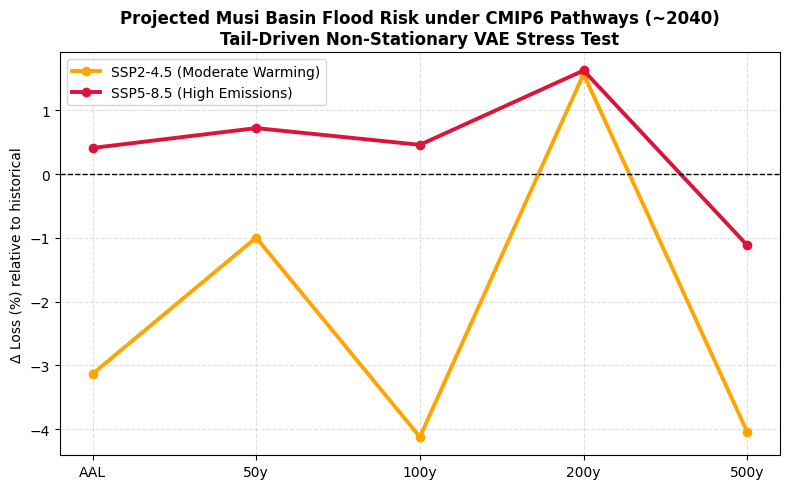

In [161]:
import matplotlib.pyplot as plt

# ============================================
# SSP-Framed Climate Impact Data (2040)
# ============================================

metrics = ["AAL", "50y", "100y", "200y", "500y"]

ssp245 = [-3.133049, -0.994608, -4.120937, 1.570911, -4.044170]   # S1
ssp585 = [ 0.410949,  0.722389,  0.460459, 1.626468, -1.115267]   # S2

# ============================================
# Plot
# ============================================

plt.figure(figsize=(8, 5))

plt.plot(
    metrics,
    ssp245,
    marker="o",
    linewidth=2.8,
    color="orange",
    label="SSP2-4.5 (Moderate Warming)"
)

plt.plot(
    metrics,
    ssp585,
    marker="o",
    linewidth=2.8,
    color="crimson",
    label="SSP5-8.5 (High Emissions)"
)

plt.axhline(0, color="black", linestyle="--", linewidth=1)

plt.ylabel("Δ Loss (%) relative to historical")
plt.title(
    "Projected Musi Basin Flood Risk under CMIP6 Pathways (~2040)\n"
    "Tail-Driven Non-Stationary VAE Stress Test",
    fontsize=12,
    weight="bold"
)

plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()


---